### 렙톤 , 젯 , 팻젯 순으로 클리닝 하기
##### 렙톤이 젯이나 팻젯 안에 들어가냐 , 그리고 렙톤이 젯 팻젯으로 보이냐 그 두개로 생각해야함. 
##### 내 아날리시스 의 경우 들어가는건 걱정 안 해도 됨.
##### 근데 문제가 렙톤이 젯이나 팻젯으로 보이는 경우도 있고 다른 젯이나 팻젯 안에 렙톤이 들어가는 경우가 있으면 빼야함 
#### 추가로 bjet안에 다른 topjet 이 겹치는 경우 있으면 빼야함

In [ ]:

from importlib import import_module
import os
import sys
import argparse
import linecache
import uproot
import vector
import math
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from tqdm import tqdm  # ✅ 진행률 표시
import glob

vector.register_awkward()

# 모든 .root 파일 경로 가져오기
path = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV/"
file_list = sorted(glob.glob(path + "*.root"))

cleaned_Nmother_muon_pt = []
cleaned_WR_mother_muon_pt = []
all_muon_pt = []

cleaned_ak4jet_pt = []
all_ak4jet_pt = []

cleaned_ak8jet_pt = []
all_ak8jet_pt = []

def overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return target[mask]

def find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return jets[closest_idx_per_obj]





# tqdm으로 파일 리스트 순회
for sample in tqdm(file_list, desc="Processing ROOT files"):
    file = uproot.open(sample)
    events = file["Events"]

    keys = events.keys()

    vector.register_awkward()  

    lhe_pdgid = events["LHEPart_pdgId"].array()
    lhe_pt = events["LHEPart_pt"].array()
    lhe_eta = events["LHEPart_eta"].array()
    lhe_phi = events["LHEPart_phi"].array()
    lhe_mass = events["LHEPart_mass"].array()
    lhe_status = events["LHEPart_status"].array()

    ak4_eta = events["Jet_eta"].array()
    ak4_phi = events["Jet_phi"].array()
    ak4_pt = events["Jet_pt"].array()
    ak4_flavor = events["Jet_hadronFlavour"].array()
    ak4_mass = events["Jet_mass"].array()
    btag = events["Jet_btagPNetB"].array()

    ## Fatjet 
    fatjet_pt = events["FatJet_pt"].array()
    fatjet_eta = events["FatJet_eta"].array()
    fatjet_phi = events["FatJet_phi"].array()
    fatjet_mass = events["FatJet_mass"].array()

    gen_pdgid = events["GenPart_pdgId"].array()
    gen_pt = events["GenPart_pt"].array()
    gen_eta = events["GenPart_eta"].array()
    gen_phi = events["GenPart_phi"].array()
    gen_mass = events["GenPart_mass"].array()

    reco_muon_pt = events["Muon_pt"].array()
    reco_muon_eta = events["Muon_eta"].array()
    reco_muon_phi = events["Muon_phi"].array()
    reco_muon_mass = events["Muon_mass"].array()



    # mask 
    bottom_mask = (lhe_pdgid == 5) | (lhe_pdgid == -5)
    bottom_eta = lhe_eta[bottom_mask]
    bottom_phi = lhe_phi[bottom_mask]
    bottom_pt = lhe_pt[bottom_mask]
    bottom_mass = lhe_mass[bottom_mask]

    topmask = (gen_pdgid == 6) | (gen_pdgid == -6)
    top_eta = gen_eta[topmask]
    top_eta = top_eta[:, 1:2]  # top quark 1 = WR* mother
    top_phi = gen_phi[topmask]
    top_phi = top_phi[:, 0:1]
    top_pt = gen_pt[topmask]
    top_pt = top_pt[:, 0:1]  # top quark 1 = WR* mother
    top_mass = gen_mass[topmask]
    top_mass = top_mass[:, 0:1]  # top quark 1 = WR* mother

    bottompt = bottom_pt[:, 2:3]#bottom quark 1 = WR* mother
    bottometa = bottom_eta[:, 2:3]
    bottomphi = bottom_phi[:, 2:3]
    bottommass = bottom_mass[:, 2:3]

    muon_mask = (lhe_pdgid == 13) | (lhe_pdgid == -13)
    muon_pt = lhe_pt[muon_mask]
    muon_eta = lhe_eta[muon_mask]
    muon_phi = lhe_phi[muon_mask]
    muon_mass = lhe_mass[muon_mask]

    reco_muon_pt = reco_muon_pt[:]
    reco_muon_eta = reco_muon_eta[:]
    reco_muon_phi = reco_muon_phi[:]
    reco_muon_mass = reco_muon_mass[:] 


    n_mother_muon_mass = muon_mass[:,0:1] # muon 1 = WR* mother
    n_mother_muon_pt = muon_pt[:,0:1] # muon 1 = WR* mother
    n_mother_muon_eta = muon_eta[:,0:1]
    n_mother_muon_phi = muon_phi[:,0:1]

    WR_mother_muon_mass = muon_mass[:,2:3] # muon 2 = WR* mother
    WR_mother_muon_pt = muon_pt[:,2:3] # muon 2 = WR* mother
    WR_mother_muon_eta = muon_eta[:,2:3]
    WR_mother_muon_phi = muon_phi[:,1:2]  


    lhe_muons = ak.zip({
        "pt": muon_pt,
        "eta": muon_eta,
        "phi": muon_phi,
        "mass": muon_mass
    }, with_name = "Momentum4D")

    n_mother_muon = ak.zip({
        "pt": n_mother_muon_pt,
        "eta": n_mother_muon_eta,
        "phi": n_mother_muon_phi,
        "mass": n_mother_muon_mass
    }, with_name = "Momentum4D")

    WR_mother_muon = ak.zip({
        "pt": WR_mother_muon_pt,
        "eta": WR_mother_muon_eta,
        "phi": WR_mother_muon_phi,
        "mass": WR_mother_muon_mass
    }, with_name = "Momentum4D")

    reco_muons = ak.zip({
        "pt": reco_muon_pt,
        "eta": reco_muon_eta,
        "phi": reco_muon_phi,
        "mass": reco_muon_mass
    }, with_name = "Momentum4D")

    ak4 = ak.zip({
        "pt": ak4_pt,
        "eta": ak4_eta,
        "phi": ak4_phi,
        "mass": ak4_mass
    }, with_name = "Momentum4D")

    lhe_bottom = ak.zip({ ## bottom quark 1 = WR* mother
        "pt": bottompt,
        "eta": bottometa,
        "phi": bottomphi,
        "mass": bottommass
    }, with_name = "Momentum4D")

    gen_top = ak.zip({
        "eta": top_eta,
        "phi": top_phi,
        "pt": top_pt,
        "mass": top_mass
    }, with_name = "Momentum4D")

    fatjets = ak.zip({
        "pt": fatjet_pt,
        "eta": fatjet_eta,
        "phi": fatjet_phi,
        "mass": fatjet_mass
    }, with_name="Momentum4D")

    

    ak8jet = find_closest_jet(gen_top, fatjets)
    ak4jet = find_closest_jet(lhe_bottom, ak4)
    nmother_muon = find_closest_jet(n_mother_muon, reco_muons)
    wrmother_muon = find_closest_jet(WR_mother_muon, reco_muons)
    all_mother_muon = find_closest_jet(lhe_muons, reco_muons)
    ## 1. 뮤온은 자기 자신끼리만 안 겹치면 그대로 사용
    overlap_nmother_cleaned = overlap_removal(nmother_muon, [reco_muons]) #lepton lepton cleaning
    overlap_WR_mother_cleaned = overlap_removal(wrmother_muon, [reco_muons]) #lepton lepton cleaning

    cleaned_Nmother_muon_pt.append(overlap_nmother_cleaned["pt"])
    cleaned_WR_mother_muon_pt.append(overlap_WR_mother_cleaned["pt"])
    all_muon_pt.append(lhe_muons["pt"])
    # 2. b jet은 뮤온이랑만 안 겹치면 그대로 사용 
    overlap_ak4_cleaned = overlap_removal(ak4jet, [all_mother_muon, ak4])
    

    cleaned_ak4jet_pt.append(overlap_ak4_cleaned["pt"])
    all_ak4jet_pt.append(ak4jet["pt"])
    # 3. fatjet은 뮤온이랑 b jet이랑 안 겹쳐야 사용
    overlap_fatjet_cleaned = overlap_removal(ak8jet, [all_mother_muon , ak4 ,fatjets], cut=0.8)

    cleaned_ak8jet_pt.append(overlap_fatjet_cleaned["pt"])
    all_ak8jet_pt.append(fatjets["pt"])


    
    
    






Processing ROOT files:   0%|          | 0/80 [00:00<?, ?it/s]

Processing ROOT files: 100%|██████████| 80/80 [01:51<00:00,  1.39s/it]


In [5]:
print(len((ak.flatten(ak.flatten(cleaned_Nmother_muon_pt)))))
print(len((ak.flatten(ak.flatten(cleaned_WR_mother_muon_pt)))))
print(len((ak.flatten(ak.flatten(all_muon_pt)))))
print(len((ak.flatten(ak.flatten(cleaned_ak8jet_pt)))))
print(len((ak.flatten(ak.flatten(all_ak8jet_pt)))))
print(len((ak.flatten(ak.flatten(cleaned_ak4jet_pt)))))
print(len((ak.flatten(ak.flatten(all_ak4jet_pt)))))

37064
36206
80000
123
146738
37668
40000


In [15]:

from importlib import import_module
import os
import sys
import argparse
import linecache
import uproot
import vector
import math
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from tqdm import tqdm  # ✅ 진행률 표시
import glob

vector.register_awkward()

sample = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-2500_13p6TeV/Run3Summer22NanoAODv12_WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-2500_13p6TeV_1.root"
file = uproot.open(sample)
events = file["Events"]

keys = events.keys()
lhe_pdgid = events["LHEPart_pdgId"].array()
lhe_pt = events["LHEPart_pt"].array()
lhe_eta = events["LHEPart_eta"].array()
lhe_phi = events["LHEPart_phi"].array()
lhe_mass = events["LHEPart_mass"].array()
lhe_status = events["LHEPart_status"].array()

ak4_eta = events["Jet_eta"].array()
ak4_phi = events["Jet_phi"].array()
ak4_pt = events["Jet_pt"].array()
ak4_flavor = events["Jet_hadronFlavour"].array()
ak4_mass = events["Jet_mass"].array()
btag = events["Jet_btagPNetB"].array()

## Fatjet 
fatjet_pt = events["FatJet_pt"].array()
fatjet_eta = events["FatJet_eta"].array()
fatjet_phi = events["FatJet_phi"].array()
fatjet_mass = events["FatJet_mass"].array()

gen_pdgid = events["GenPart_pdgId"].array()
gen_pt = events["GenPart_pt"].array()
gen_eta = events["GenPart_eta"].array()
gen_phi = events["GenPart_phi"].array()
gen_mass = events["GenPart_mass"].array()

reco_muon_pt = events["Muon_pt"].array()
reco_muon_eta = events["Muon_eta"].array()
reco_muon_phi = events["Muon_phi"].array()
reco_muon_mass = events["Muon_mass"].array()



# mask 
bottom_mask = (lhe_pdgid == 5) | (lhe_pdgid == -5)
bottom_eta = lhe_eta[bottom_mask]
bottom_phi = lhe_phi[bottom_mask]
bottom_pt = lhe_pt[bottom_mask]
bottom_mass = lhe_mass[bottom_mask]

topmask = (gen_pdgid == 6) | (gen_pdgid == -6)
top_eta = gen_eta[topmask]
top_eta = top_eta[:, 0:1]  # top quark 1 = WR* mother
top_phi = gen_phi[topmask]
top_phi = top_phi[:, 0:1]
top_pt = gen_pt[topmask]
top_pt = top_pt[:, 0:1]  # top quark 1 = WR* mother
top_mass = gen_mass[topmask]
top_mass = top_mass[:, 0:1]  # top quark 1 = WR* mother

bottompt = bottom_pt[:, 1:2]#bottom quark 1 = WR* mother
bottometa = bottom_eta[:, 1:2]
bottomphi = bottom_phi[:, 1:2]
bottommass = bottom_mass[:, 1:2]

muon_mask = (lhe_pdgid == 13) | (lhe_pdgid == -13)
muon_pt = lhe_pt[muon_mask]
muon_eta = lhe_eta[muon_mask]
muon_phi = lhe_phi[muon_mask]
muon_mass = lhe_mass[muon_mask]

reco_muon_pt = reco_muon_pt[:]
reco_muon_eta = reco_muon_eta[:]
reco_muon_phi = reco_muon_phi[:]
reco_muon_mass = reco_muon_mass[:] 


n_mother_muon_mass = muon_mass[:,0:1] # muon 1 = WR* mother
n_mother_muon_pt = muon_pt[:,0:1] # muon 1 = WR* mother
n_mother_muon_eta = muon_eta[:,0:1]
n_mother_muon_phi = muon_phi[:,0:1]

WR_mother_muon_mass = muon_mass[:,1:2] # muon 2 = WR* mother
WR_mother_muon_pt = muon_pt[:,1:2] # muon 2 = WR* mother
WR_mother_muon_eta = muon_eta[:,1:2]
WR_mother_muon_phi = muon_phi[:,1:2]  

lhe_muons = ak.zip({
        "pt": muon_pt,
        "eta": muon_eta,
        "phi": muon_phi,
        "mass": muon_mass
}, with_name = "Momentum4D")

reco_muons = ak.zip({
        "pt": reco_muon_pt,
        "eta": reco_muon_eta,
        "phi": reco_muon_phi,
        "mass": reco_muon_mass
    }, with_name = "Momentum4D")
n_mother_muon = ak.zip({
"pt": n_mother_muon_pt,
        "eta": n_mother_muon_eta,
    "phi": n_mother_muon_phi,
        "mass": n_mother_muon_mass
    }, with_name = "Momentum4D")

WR_mother_muon = ak.zip({
        "pt": WR_mother_muon_pt,
        "eta": WR_mother_muon_eta,
        "phi": WR_mother_muon_phi,
        "mass": WR_mother_muon_mass
    }, with_name = "Momentum4D")


ak4 = ak.zip({
        "pt": ak4_pt,
        "eta": ak4_eta,
        "phi": ak4_phi,
        "mass": ak4_mass
    }, with_name = "Momentum4D")

lhe_bottom = ak.zip({ ## bottom quark 1 = WR* mother
        "pt": bottompt,
        "eta": bottometa,
        "phi": bottomphi,
        "mass": bottommass
    }, with_name = "Momentum4D")

gen_top = ak.zip({
        "eta": top_eta,
        "phi": top_phi,
        "pt": top_pt,
        "mass": top_mass
    }, with_name = "Momentum4D")

fatjets = ak.zip({
        "pt": fatjet_pt,
        "eta": fatjet_eta,
        "phi": fatjet_phi,
        "mass": fatjet_mass
    }, with_name="Momentum4D")

def overlap_removal(target, cleans, cut=0.4, dphi=False):
            mask = ak.ones_like(target["pt"], dtype=bool)
            for clean in cleans:
                pairs = ak.cartesian([target, clean], nested=True) # axis 0 = #event , axis 1 = target , axis 2 = clean
                delta = np.abs(pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
                mask = mask & (ak.min(delta, axis=2) > cut)
            return target[mask]

def find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return jets[closest_idx_per_obj]

a = find_closest_jet(gen_top, fatjets)
b= overlap_removal(a, [lhe_muons], cut=0.8)["pt"]
c = overlap_removal(a, [reco_muons], cut=0.8)["pt"]
d = overlap_removal(n_mother_muon, [WR_mother_muon])["pt"]
print(len(ak.flatten(a["pt"])))
print(len(ak.flatten(b)))
print(len(ak.flatten(c)))
print(len(ak.flatten(d)))


500
460
257
494


### reco level 에서 pt 순서대로 골랐을 때

muon_num2_mask [True, True, True, True, True, True, ..., True, True, True, True, True, True]


/tmp/ipykernel_1303024/4021121535.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


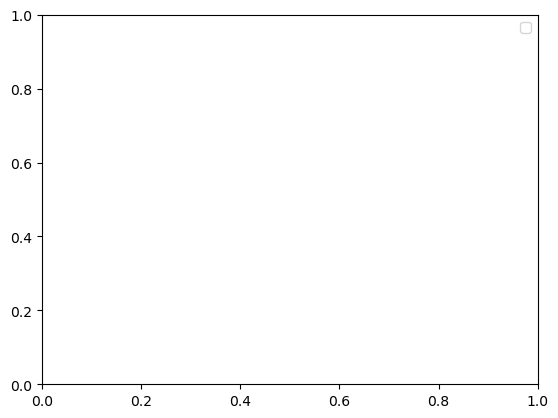

117


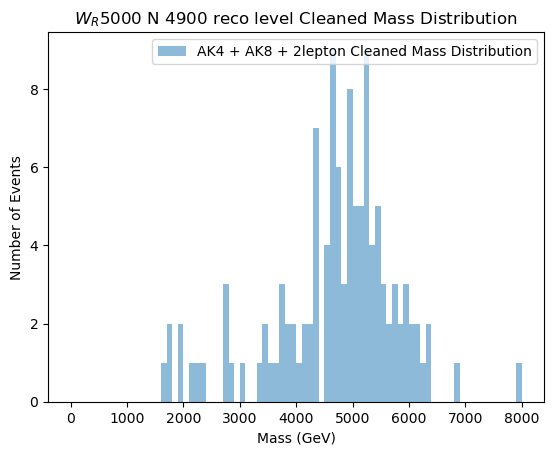

In [163]:

from importlib import import_module
import os
import sys
import argparse
import linecache
import uproot
import vector
import math
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from tqdm import tqdm  # ✅ 진행률 표시
import glob

vector.register_awkward()

sample = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV/Run3Summer22NanoAODv12_WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV_6.root"
file = uproot.open(sample)
events = file["Events"]

keys = events.keys()

btag = events["Jet_btagPNetB"].array()
def overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return target[mask]
def btag4_overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return btag[mask]

def overlap_itself_removal(target, cleans, cut=0.4, dphi=False):
            mask = ak.ones_like(target["pt"], dtype=bool)
            for clean in cleans:
                pairs = ak.cartesian([target, clean], nested=True) # axis 0 = #event , axis 1 = target , axis 2 = clean
                delta = np.abs(pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
                mask = mask & (ak.min(delta, axis=2) > cut)
            return target[mask]
def find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return jets[closest_idx_per_obj]

def btag_find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return btag[closest_idx_per_obj]
def Select(inputcoll,etamax,ptmin) :
    output = []
    for obj in inputcoll :
        if abs(obj.eta) < etamax and obj.pt > ptmin : output.append(obj)
    return output 





lhe_pdgid = events["LHEPart_pdgId"].array()
lhe_pt = events["LHEPart_pt"].array()
lhe_eta = events["LHEPart_eta"].array()
lhe_phi = events["LHEPart_phi"].array()
lhe_mass = events["LHEPart_mass"].array()

bottom_mask = (lhe_pdgid == 5) | (lhe_pdgid == -5)
lhe_muon_mask = (lhe_pdgid == 13) | (lhe_pdgid == -13)

lhe_particle  = ak.zip({
    "pt": lhe_pt,
    "eta": lhe_eta,
    "phi": lhe_phi,
    "mass": lhe_mass
}, with_name = "Momentum4D")

lhe_bottoms = lhe_particle[bottom_mask]
lhe_bottoms_eta = lhe_bottoms["eta"][:, 1:2]  
lhe_bottoms_phi = lhe_bottoms["phi"][:, 1:2]
lhe_bottoms_pt = lhe_bottoms["pt"][:, 1:2]  
lhe_bottoms_mass = lhe_bottoms["mass"][:, 1:2]  # bottom quark 1 = WR* mother

lhe_bottom2_eta = lhe_bottoms["eta"][:, 0:1]
lhe_bottom2_phi = lhe_bottoms["phi"][:, 0:1]
lhe_bottom2_pt = lhe_bottoms["pt"][:, 0:1]
lhe_bottom2_mass = lhe_bottoms["mass"][:, 0:1]  # top mother bottom quark

lhe_bottom = ak.zip({
    "eta": lhe_bottoms_eta,
    "phi": lhe_bottoms_phi,
    "pt": lhe_bottoms_pt,
    "mass": lhe_bottoms_mass
}, with_name = "Momentum4D")

lhe_bottom2 = ak.zip({
    "eta": lhe_bottom2_eta,
    "phi": lhe_bottom2_phi,
    "pt": lhe_bottom2_pt,
    "mass": lhe_bottom2_mass
}, with_name = "Momentum4D")

lhe_muons  = lhe_particle[lhe_muon_mask]
lhe_muons_eta = lhe_muons["eta"][:]
lhe_muons_phi = lhe_muons["phi"][:]
lhe_muons_pt = lhe_muons["pt"][:]
lhe_muons_mass = lhe_muons["mass"][:]

n_mother_muon_mass = lhe_muons_mass[:,0:1] 
n_mother_muon_pt = lhe_muons_pt[:,0:1] 
n_mother_muon_eta = lhe_muons_eta[:,0:1]
n_mother_muon_phi = lhe_muons_phi[:,0:1]

wr_mother_muon_mass = lhe_muons_mass[:,1:2]
wr_mother_muon_pt = lhe_muons_pt[:,1:2]
wr_mother_muon_eta = lhe_muons_eta[:,1:2]
wr_mother_muon_phi = lhe_muons_phi[:,1:2]

lhe_muon = ak.zip({
    "pt": lhe_muons_pt,
    "eta": lhe_muons_eta,
    "phi": lhe_muons_phi,
    "mass": lhe_muons_mass
}, with_name = "Momentum4D")

n_mother_muon = ak.zip({
    "pt": n_mother_muon_pt,
    "eta": n_mother_muon_eta,
    "phi": n_mother_muon_phi,
    "mass": n_mother_muon_mass
}, with_name = "Momentum4D")

wr_mother_muon = ak.zip({
    "pt": wr_mother_muon_pt,
    "eta": wr_mother_muon_eta,
    "phi": wr_mother_muon_phi,
    "mass": wr_mother_muon_mass
}, with_name = "Momentum4D")



genparticle_pdgid = events["GenPart_pdgId"].array()
genparticle_pt = events["GenPart_pt"].array()
genparticle_eta = events["GenPart_eta"].array()
genparticle_phi = events["GenPart_phi"].array()
genparticle_mass = events["GenPart_mass"].array()
genparticle_statusFlags = events["GenPart_statusFlags"].array()

top_mask = (genparticle_pdgid == 6) | (genparticle_pdgid == -6)


genparticle  = ak.zip({
    "pt": genparticle_pt,
    "eta": genparticle_eta,
    "phi": genparticle_phi,
    "mass": genparticle_mass
}, with_name = "Momentum4D")



gentops = genparticle[top_mask]
gentops_eta = gentops["eta"][:, 0:1]  
gentops_phi = gentops["phi"][:, 0:1]
gentops_pt = gentops["pt"][:, 0:1]  
gentops_mass = gentops["mass"][:, 0:1]  


gentop = ak.zip({
    "eta": gentops_eta,
    "phi": gentops_phi,
    "pt": gentops_pt,
    "mass": gentops_mass
}, with_name = "Momentum4D")


### reco level
ak4_eta = events["Jet_eta"].array()
ak4_phi = events["Jet_phi"].array()
ak4_pt = events["Jet_pt"].array()
ak4_flavor = events["Jet_hadronFlavour"].array()
ak4_mass = events["Jet_mass"].array()
btag = events["Jet_btagPNetB"].array()

ak4 = ak.zip({
        "pt": ak4_pt,
        "eta": ak4_eta,
        "phi": ak4_phi,
        "mass": ak4_mass
    }, with_name = "Momentum4D")

## Fatjet 
fatjet_pt = events["FatJet_pt"].array()
fatjet_eta = events["FatJet_eta"].array()
fatjet_phi = events["FatJet_phi"].array()
fatjet_mass = events["FatJet_mass"].array()

fatjets = ak.zip({
        "pt": fatjet_pt,
        "eta": fatjet_eta,
        "phi": fatjet_phi,
        "mass": fatjet_mass
    }, with_name="Momentum4D")

## muons
reco_muon_pt = events["Muon_pt"].array()
reco_muon_eta = events["Muon_eta"].array()
reco_muon_phi = events["Muon_phi"].array()
reco_muon_mass = events["Muon_mass"].array()

reco_muons = ak.zip({
        "pt": reco_muon_pt,
        "eta": reco_muon_eta,
        "phi": reco_muon_phi,
        "mass": reco_muon_mass
    }, with_name = "Momentum4D")



closest_muon1 = find_closest_jet(n_mother_muon, reco_muons)
closest_muon2 = find_closest_jet(wr_mother_muon, reco_muons)
closest_bjet = find_closest_jet(lhe_bottom, ak4)
closest_ak8jet = find_closest_jet(gentop, fatjets)
notcleaned_mass = closest_muon1 + closest_muon2 + closest_bjet + closest_ak8jet
#plt.hist(notcleaned_mass.mass, bins=100, range=(0, 8000), alpha=0.5, label='Not Cleaned Mass Distribution')
#####################################################
cleaned_Nmother_muon_pt = []
cleaned_WR_mother_muon_pt = []
all_muon_pt = []
cleaned_ak4jet_pt = []
all_ak4jet_pt = []
cleaned_ak8jet_pt =[]
all_ak8jet_pt = []
#####################################################
#print(btag_find_closest_jet(lhe_bottom, ak4))
#plt.hist(ak.flatten(btag_find_closest_jet(lhe_bottom, ak4)), bins=30, range=(0, 1), alpha=0.5, label='B tag score  ak4-jet Distribution')
plt.legend()
#print("lhe muon",lhe_muon["pt"])
#print("reco muon",reco_muons["pt"])

muon_num2_mask = ak.num(reco_muons["pt"]) > 1
print("muon_num2_mask",muon_num2_mask)

first_muon = reco_muons[:, 0:1]  # 첫 번째 뮤온
second_muon = reco_muons[:, 1:2]  # 두 번째 뮤온
topmother_b_ak4jet = find_closest_jet(lhe_bottom2, ak4)
### 겹치는거 확인 

first_muon_cleaned = overlap_removal(first_muon, [reco_muons], cut=0.4)
second_muon_cleaned = overlap_removal(second_muon, [reco_muons], cut=0.4)
#print("first muon cleaned", first_muon_cleaned["pt"])
#print("second muon cleaned", second_muon_cleaned["pt"])

### ak4 중에서 렙톤 근처에 없고 근처에 ak4없는것 중에 제일 큰 pt
signalb_cleaned = overlap_removal(ak4, [reco_muons, ak4], cut=0.4)
btaggedb_cleaned = btag4_overlap_removal(ak4, [first_muon_cleaned,second_muon_cleaned, ak4], cut=0.4)
plt.show()
#plt.hist(ak.flatten(btaggedb_cleaned), bins=30, range=(0, 1), alpha=0.5, label='B-tagged b-jet Distribution')
sortidx = ak.argsort(-signalb_cleaned["pt"], axis=1)  # pt 기준으로 내림차순 정렬
signalb_cleaend_sorted = signalb_cleaned[sortidx][:, 0:1]  # 가장 큰 pt를 가진 jet만 선택

sorted_btaggedb_cleaned = btaggedb_cleaned[sortidx][:, 0:1]  # 가장 큰 pt를 가진 jet에 대한 b-tag 정보 선택
sorted_btaggedb_cleaned2 = btaggedb_cleaned[sortidx][:, 1:2]  # 가장 큰 pt를 가진 jet에 대한 b-tag 정보 선택
#print(sorted_btaggedb_cleaned)
#plt.hist(ak.flatten(sorted_btaggedb_cleaned), bins=30, range=(0, 1), alpha=0.5, label='B-tagged b-jet Distribution')
#plt.hist(ak.flatten(sorted_btaggedb_cleaned2), bins=30, range=(0, 1), alpha=0.5, label='B-tagged b-jet Distribution2')
plt.show()

btagging = sorted_btaggedb_cleaned > 0.5
signalb_cleaend_sorted = signalb_cleaend_sorted[btagging]
sortidx = ak.argsort(-signalb_cleaend_sorted["pt"], axis=1)  # pt 기준으로 내림차순 정렬
leading_tagged_bjet = signalb_cleaend_sorted[sortidx][:, 0:1]  # 가장 큰 pt를 가진 jet만 선택

#print("leading b jet", leading_tagged_bjet["pt"])

#print("bjet cleaned", signalb_cleaend_sorted["pt"])
#print("all b jet",ak4["pt"])
#print("signal b jet",ak4jet["pt"])
closest_bjet = find_closest_jet(lhe_bottom, ak4)
#print("closest b jet", closest_bjet["pt"])
#plt.hist(ak.flatten(signalb_cleaend_sorted["pt"]), bins=30, range=(0, 1000), alpha=0.5, label='Cleaned b-jet pt Distribution')
#plt.hist(ak.flatten(closest_bjet["pt"]), bins=30, range=(0, 1000), alpha=0.5, label='Closest b-jet pt Distribution')
### ak8 중에서 렙톤 근처에 없고 위에서 뽑은 ak4가 안 들어있는거 
#overlap_topmother_b_cleaned = overlap_itself_removal(ak4, [topmother_b_ak4jet])
signaltop_cleaned = overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned,leading_tagged_bjet, fatjets], cut=0.8)
#print("ak8 cleaned", signaltop_cleaned["pt"])
sortidx8 = ak.argsort(-signaltop_cleaned["pt"], axis=1)  # pt 기준으로 내림차순 정렬
signaltop_cleaned_sorted = signaltop_cleaned[sortidx8][:, 0:1]
#print("ak8 cleaned", signaltop_cleaned_sorted["pt"])
#print(len(ak.flatten(signaltop_cleaned_sorted["pt"])))
#print("all top jet",fatjets["pt"])
closest_ak8jet = find_closest_jet(gentop, fatjets)
#plt.hist(ak.flatten(signaltop_cleaned_sorted["pt"]), bins=100, range=(0, 8000), alpha=0.5, label='Cleaned ak8 pt Distribution')
#plt.hist(ak.flatten(closest_ak8jet["pt"]), bins=100, range=(0, 8000), alpha=0.5, label='Closest ak8 pt Distribution')

### 빈 이벤트 빼고 연산하는 마스크 만들기
first_muon_cleaned_pt = ak.sum(first_muon_cleaned["pt"], axis=1)
second_muon_cleaned_pt = ak.sum(second_muon_cleaned["pt"], axis=1)
signalb_cleaned_pt = ak.sum(leading_tagged_bjet["pt"], axis=1)
signaltop_cleaned_pt = ak.sum(signaltop_cleaned_sorted["pt"], axis=1)

leftmask = (first_muon_cleaned_pt > 0.0) & (second_muon_cleaned_pt > 0.0) & (signalb_cleaned_pt > 0.0) & (signaltop_cleaned_pt > 0.0) 
first_muon_cleaned = first_muon_cleaned[leftmask]
second_muon_cleaned = second_muon_cleaned[leftmask]
signalb_cleaend_sorted = leading_tagged_bjet[leftmask]
signaltop_cleaned_sorted = signaltop_cleaned_sorted[leftmask]

combined_p4 = first_muon_cleaned + second_muon_cleaned + signalb_cleaend_sorted + signaltop_cleaned_sorted
plt.hist(combined_p4.mass, bins=80, range=(0, 8000), alpha=0.5, label='AK4 + AK8 + 2lepton Cleaned Mass Distribution')
plt.xlabel('Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('$W_{R}$5000 N 4900 reco level Cleaned Mass Distribution')
plt.legend()

print(len(combined_p4.mass))
lhe_combined_p4 = n_mother_muon + wr_mother_muon + lhe_bottom + gentop
#plt.hist(lhe_combined_p4.mass, bins=80, range=(0, 8000), alpha=0.5, label='lhe mass')
plt.show()

#plt.scatter(ak.flatten(signaltop_cleaned_sorted["pt"]), ak.flatten(signalb_cleaend_sorted["pt"]), alpha=0.5)
#plt.xlabel("Cleaned AK8 Jet $p_T$ [GeV]")
#plt.ylabel("Cleaned AK4 Jet $p_T$ [GeV]")
#plt.title("Correlation between Cleaned AK8 and AK4 Jet $p_T$")
#plt.show()

'''

### ak8 먼저 뽑는 경우 

first_muon = reco_muons[:, 0:1]  # 첫 번째 뮤온
second_muon = reco_muons[:, 1:2]  # 두 번째 뮤온

### 겹치는거 확인 

first_muon_cleaned = overlap_removal(first_muon, [reco_muons], cut=0.4)
second_muon_cleaned = overlap_removal(second_muon, [reco_muons], cut=0.4)

## ak8 selection
signaltop_cleaned = overlap_removal(fatjets, [reco_muons, fatjets], cut=0.8)
signaltop_cleaned_sorted = signaltop_cleaned[ak.argsort(signaltop_cleaned["pt"], axis=1, ascending=False)]
signaltop_cleaned_sorted = signaltop_cleaned_sorted[:, 0:1]

## ak4 selection
signalb_cleaned = overlap_removal(ak4, [reco_muons, fatjets ,ak4 ], cut=0.4)
signalb_cleaned_sorted = signalb_cleaned[ak.argsort(signalb_cleaned["pt"], axis=1, ascending=False)]
signalb_cleaend_sorted = signalb_cleaned_sorted[:, 0:1]


first_muon_cleaned_pt = ak.sum(first_muon_cleaned["pt"], axis=1)
second_muon_cleaned_pt = ak.sum(second_muon_cleaned["pt"], axis=1)
signaltop_cleaned_pt = ak.sum(signaltop_cleaned_sorted["pt"], axis=1)
signalb_cleaned_pt = ak.sum(signalb_cleaend_sorted["pt"], axis=1)

leftmask = (signaltop_cleaned_pt > 0.0) & (signalb_cleaned_pt > 0.0) & (first_muon_cleaned_pt > 0.0) & (second_muon_cleaned_pt > 0.0)

first_muon_cleaned = first_muon_cleaned[leftmask]
second_muon_cleaned = second_muon_cleaned[leftmask]
signaltop_cleaned_sorted = signaltop_cleaned_sorted[leftmask]
signalb_cleaend_sorted = signalb_cleaend_sorted[leftmask]


combined_p4 = first_muon_cleaned + second_muon_cleaned + signalb_cleaend_sorted + signaltop_cleaned_sorted
plt.hist(combined_p4.mass, bins=100, range=(1000, 7000), alpha=0.5, label='recolevel ak8 first Mass Distribution')
plt.xlabel('Mass (GeV)')
plt.ylabel('Number of Events')
print(len(combined_p4.mass))
'''


#### cut adjusted

btag = events["Jet_btagPNetB"].array()
#print("ak4pt", ak4_pt[17])
#print("btag", btag[17])

### 렙톤 , ak8 두 개 이상 있는 경우 , 렙톤이 근처에 없고 나머지가 두개 이상 있어야 하고 그 중 큰 두개 

ak8 num [4, 4, 4, 3, 3, 4, 3, 4, 4, 5, 5, 5, 2, ..., 4, 3, 5, 4, 5, 4, 4, 4, 5, 3, 5, 6]
[[0.636, 0.104], [None, None, None, None], ..., [...], [0.306, 0.164, -1]]
bjet tagged [0.636, None, 0.167, 0.231, 0.79, 0.112, ..., 0.0583, 0.2, None, 0.0535, 0.306]


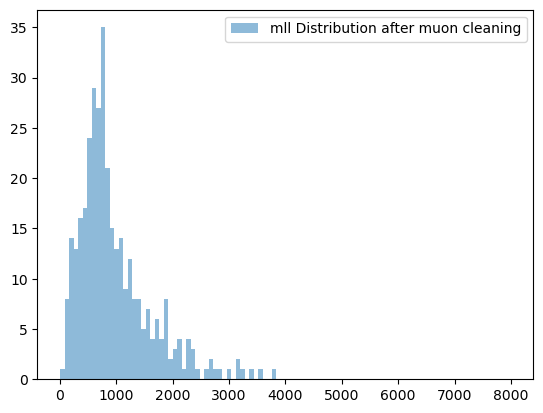

450
500
fatjets [[1.85e+03, 1.76e+03, 974, 784], ..., [2.2e+03, 1.47e+03, 901, ..., 329, 174]]
ak8 first cleaned [[974], [None], [1.69e+03], [564], ..., [None], [1.95e+03], [1.47e+03]]
ak8 second cleaned [[784], [None], [298], [324], [], ..., [1.35e+03], [None], [1.73e+03], [901]]


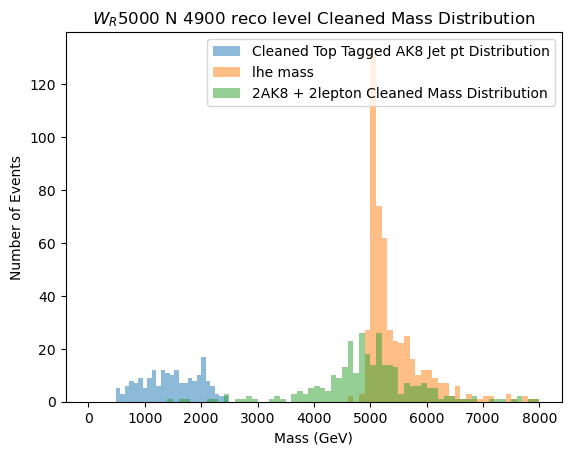

299
[[1.55e+03, 1.52e+03], [823, 200], [...], ..., [383, 544], [2.04e+03, 290]]
[[1.65e+03, 1.46e+03, 310, 25.2], ..., [2.1e+03, 276, 72.7, ..., 31.5, 16.2]]


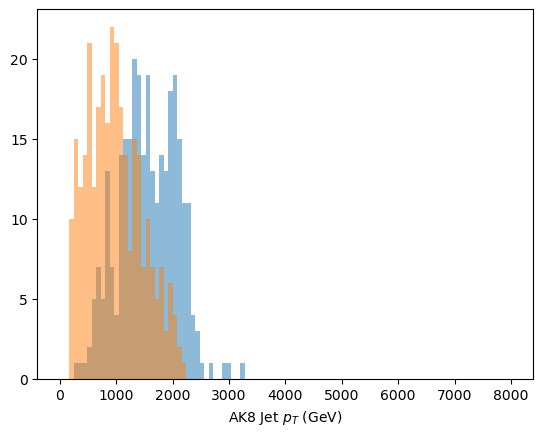

In [192]:

from importlib import import_module
import os
import sys
import argparse
import linecache
import uproot
import vector
import math
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from tqdm import tqdm  # ✅ 진행률 표시
import glob

vector.register_awkward()

sample = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV/Run3Summer22NanoAODv12_WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV_6.root"
file = uproot.open(sample)
events = file["Events"]

keys = events.keys()


def overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return target[mask]

def toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return toptagging[mask]
def toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return toptagging[mask]

def sdm_overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return softdrop_mass[mask]

def overlap_itself_removal(target, cleans, cut=0.4, dphi=False):
            mask = ak.ones_like(target["pt"], dtype=bool)
            for clean in cleans:
                pairs = ak.cartesian([target, clean], nested=True) # axis 0 = #event , axis 1 = target , axis 2 = clean
                delta = np.abs(pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
                mask = mask & (ak.min(delta, axis=2) > cut)
            return target[mask]
def find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return jets[closest_idx_per_obj]
def btag_find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return btagging[closest_idx_per_obj]
def Select(inputcoll,etamax,ptmin) :
    output = []
    for obj in inputcoll :
        if abs(obj.eta) < etamax and obj.pt > ptmin : output.append(obj)
    return output 





lhe_pdgid = events["LHEPart_pdgId"].array()
lhe_pt = events["LHEPart_pt"].array()
lhe_eta = events["LHEPart_eta"].array()
lhe_phi = events["LHEPart_phi"].array()
lhe_mass = events["LHEPart_mass"].array()

bottom_mask = (lhe_pdgid == 5) | (lhe_pdgid == -5)
lhe_muon_mask = (lhe_pdgid == 13) | (lhe_pdgid == -13)

lhe_particle  = ak.zip({
    "pt": lhe_pt,
    "eta": lhe_eta,
    "phi": lhe_phi,
    "mass": lhe_mass
}, with_name = "Momentum4D")

lhe_bottoms = lhe_particle[bottom_mask]
lhe_bottoms_eta = lhe_bottoms["eta"][:, 1:2]  
lhe_bottoms_phi = lhe_bottoms["phi"][:, 1:2]
lhe_bottoms_pt = lhe_bottoms["pt"][:, 1:2]  
lhe_bottoms_mass = lhe_bottoms["mass"][:, 1:2]  # bottom quark 1 = WR* mother

lhe_bottom2_eta = lhe_bottoms["eta"][:, 0:1]
lhe_bottom2_phi = lhe_bottoms["phi"][:, 0:1]
lhe_bottom2_pt = lhe_bottoms["pt"][:, 0:1]
lhe_bottom2_mass = lhe_bottoms["mass"][:, 0:1]  # top mother bottom quark

lhe_bottom = ak.zip({
    "eta": lhe_bottoms_eta,
    "phi": lhe_bottoms_phi,
    "pt": lhe_bottoms_pt,
    "mass": lhe_bottoms_mass
}, with_name = "Momentum4D")

lhe_bottom2 = ak.zip({
    "eta": lhe_bottom2_eta,
    "phi": lhe_bottom2_phi,
    "pt": lhe_bottom2_pt,
    "mass": lhe_bottom2_mass
}, with_name = "Momentum4D")

lhe_muons  = lhe_particle[lhe_muon_mask]
lhe_muons_eta = lhe_muons["eta"][:]
lhe_muons_phi = lhe_muons["phi"][:]
lhe_muons_pt = lhe_muons["pt"][:]
lhe_muons_mass = lhe_muons["mass"][:]

n_mother_muon_mass = lhe_muons_mass[:,0:1] 
n_mother_muon_pt = lhe_muons_pt[:,0:1] 
n_mother_muon_eta = lhe_muons_eta[:,0:1]
n_mother_muon_phi = lhe_muons_phi[:,0:1]

wr_mother_muon_mass = lhe_muons_mass[:,1:2]
wr_mother_muon_pt = lhe_muons_pt[:,1:2]
wr_mother_muon_eta = lhe_muons_eta[:,1:2]
wr_mother_muon_phi = lhe_muons_phi[:,1:2]

lhe_muon = ak.zip({
    "pt": lhe_muons_pt,
    "eta": lhe_muons_eta,
    "phi": lhe_muons_phi,
    "mass": lhe_muons_mass
}, with_name = "Momentum4D")

n_mother_muon = ak.zip({
    "pt": n_mother_muon_pt,
    "eta": n_mother_muon_eta,
    "phi": n_mother_muon_phi,
    "mass": n_mother_muon_mass
}, with_name = "Momentum4D")

wr_mother_muon = ak.zip({
    "pt": wr_mother_muon_pt,
    "eta": wr_mother_muon_eta,
    "phi": wr_mother_muon_phi,
    "mass": wr_mother_muon_mass
}, with_name = "Momentum4D")



genparticle_pdgid = events["GenPart_pdgId"].array()
genparticle_pt = events["GenPart_pt"].array()
genparticle_eta = events["GenPart_eta"].array()
genparticle_phi = events["GenPart_phi"].array()
genparticle_mass = events["GenPart_mass"].array()
genparticle_statusFlags = events["GenPart_statusFlags"].array()

top_mask = (genparticle_pdgid == 6) | (genparticle_pdgid == -6)


genparticle  = ak.zip({
    "pt": genparticle_pt,
    "eta": genparticle_eta,
    "phi": genparticle_phi,
    "mass": genparticle_mass
}, with_name = "Momentum4D")



gentops = genparticle[top_mask]
gentops_eta = gentops["eta"][:, 0:1]  
gentops_phi = gentops["phi"][:, 0:1]
gentops_pt = gentops["pt"][:, 0:1]  
gentops_mass = gentops["mass"][:, 0:1]  


gentop = ak.zip({
    "eta": gentops_eta,
    "phi": gentops_phi,
    "pt": gentops_pt,
    "mass": gentops_mass
}, with_name = "Momentum4D")


### reco level
ak4_eta = events["Jet_eta"].array()
ak4_phi = events["Jet_phi"].array()
ak4_pt = events["Jet_pt"].array()
ak4_flavor = events["Jet_hadronFlavour"].array()
ak4_mass = events["Jet_mass"].array()
btag = events["Jet_btagPNetB"].array()

ak4 = ak.zip({
        "pt": ak4_pt,
        "eta": ak4_eta,
        "phi": ak4_phi,
        "mass": ak4_mass
    }, with_name = "Momentum4D")

## Fatjet 
fatjet_pt = events["FatJet_pt"].array()
fatjet_eta = events["FatJet_eta"].array()
fatjet_phi = events["FatJet_phi"].array()
fatjet_mass = events["FatJet_mass"].array()

fatjets = ak.zip({
        "pt": fatjet_pt,
        "eta": fatjet_eta,
        "phi": fatjet_phi,
        "mass": fatjet_mass
    }, with_name="Momentum4D")

## muons
reco_muon_pt = events["Muon_pt"].array()
reco_muon_eta = events["Muon_eta"].array()
reco_muon_phi = events["Muon_phi"].array()
reco_muon_mass = events["Muon_mass"].array()

reco_muons = ak.zip({
        "pt": reco_muon_pt,
        "eta": reco_muon_eta,
        "phi": reco_muon_phi,
        "mass": reco_muon_mass
    }, with_name = "Momentum4D")


btagging = events["FatJet_btagDeepB"].array()
toptagging = events["FatJet_particleNetWithMass_TvsQCD"].array()
softdrop_mass = events["FatJet_msoftdrop"].array()
closest_muon1 = find_closest_jet(n_mother_muon, reco_muons)
closest_muon2 = find_closest_jet(wr_mother_muon, reco_muons)
closest_bjet = find_closest_jet(lhe_bottom, ak4)
closest_ak8jet = find_closest_jet(gentop, fatjets)
notcleaned_mass = closest_muon1 + closest_muon2 + closest_bjet + closest_ak8jet
#plt.hist(notcleaned_mass.mass, bins=100, range=(0, 8000), alpha=0.5, label='Not Cleaned Mass Distribution')
#####################################################
cleaned_Nmother_muon_pt = []
cleaned_WR_mother_muon_pt = []
all_muon_pt = []
cleaned_ak4jet_pt = []
all_ak4jet_pt = []
cleaned_ak8jet_pt =[]
all_ak8jet_pt = []
#####################################################
signalb_btagscore = ak.flatten(btag_find_closest_jet(lhe_bottom, fatjets))
#plt.hist(signalb_btagscore, bins=30, range=(0, 1), alpha=0.5, label='B tag score ak8 jet Distribution')

muon_num2_mask = ak.num(reco_muons["pt"]) > 1


first_muon = reco_muons[:, 0:1]  # 첫 번째 뮤온
second_muon = reco_muons[:, 1:2]  # 두 번째 뮤온
topmother_b_ak4jet = find_closest_jet(lhe_bottom2, ak4)
### 겹치는거 확인 

first_muon_cleaned = overlap_removal(first_muon, [reco_muons], cut=0.4)
second_muon_cleaned = overlap_removal(second_muon, [reco_muons], cut=0.4)


first_muon_cleaned_pt1 = ak.sum(first_muon_cleaned["pt"], axis=1)
second_muon_cleaned_pt2 = ak.sum(second_muon_cleaned["pt"], axis=1)
left_muon_mask = (first_muon_cleaned_pt1 > 0.0) & (second_muon_cleaned_pt2 > 0.0)  # 뮤온이 둘 다 남아있는 경우만 선
first_muon_cleaned1 = first_muon_cleaned[left_muon_mask]
second_muon_cleaned2 = second_muon_cleaned[left_muon_mask]
mll = (first_muon_cleaned1 + second_muon_cleaned2).mass
plt.hist(mll, bins=100, range=(0, 8000), alpha=0.5, label='mll Distribution after muon cleaning')
### ak 8 렙톤 클리닝 후 2개 이상 남아 있는 경우만 

ak8num = ak.sum(fatjets["pt"] > 0.0, axis=1)  # 각 이벤트에서 남아있는 ak8 jet의 개수
print("ak8 num", ak8num)
ak8num_mask = ak8num > 1  # 2개 이상인 이벤트만 선택

## 뮤온이랑 겹치지 않는 경우 
signaltop_cleaned = overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)
toptaggedak8 = toptagging_overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)
softdrop_mass_ak8 = sdm_overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)
btaggingak8 = btagging_overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)

idx_desc = ak.argsort(-signaltop_cleaned["pt"], axis=1)
firstsorted_ak8  = signaltop_cleaned[idx_desc][:, 0:1]  # 가장 큰 pt
secondsorted_ak8 = signaltop_cleaned[idx_desc][:, 1:2]  # 두 번째로 큰 pt
toptagging_fistsorted_ak8 = toptaggedak8[idx_desc][:, 0:1]  # 가장 큰 pt
toptagging_secondsorted_ak8 = toptaggedak8[idx_desc][:, 1:2]  # 두 번째로 큰 pt
btagging_fistsorted_ak8 = btaggingak8[idx_desc][:, 0:1]  # 가장 큰 pt
btagging_secondsorted_ak8 = btaggingak8[idx_desc][:, 1:2]  # 두 번째로 큰 pt


toptagging_mask = (toptaggedak8 > 0.9) & (softdrop_mass_ak8 > 120  )# ParticleNet T vs QCD threshold
toptaggedak8s = signaltop_cleaned[toptagging_mask]
toptaggedak8s_pt = ak.sum(toptaggedak8s["pt"], axis=1)

toptaggermask = toptaggedak8 > 0.9
nottoptaggedak8 = signaltop_cleaned[~toptaggermask]
nottoptaggedak8_pt = ak.sum(nottoptaggedak8["pt"], axis=1)


print(btaggingak8[~toptagging_mask])# top tagging 된 애들 제외하고 B tagging 점수 
print("bjet tagged",ak.firsts(btaggingak8[~toptagging_mask]))
#plt.hist(ak.firsts(btaggingak8[~toptagging_mask]), bins=100, range=(0, 1), alpha=0.5, label='B tag score ak8 jet Distribution')
plt.legend()
plt.show()
cleaned_top_tagged_pt=ak.flatten(signaltop_cleaned[toptagging_mask]["pt"])
plt.hist(cleaned_top_tagged_pt, bins=100, range=(0, 8000), alpha=0.5, label='Cleaned Top Tagged AK8 Jet pt Distribution')

print( sum(1 for sub in signaltop_cleaned["pt"] if len(sub) >= 2))
### 빈 이벤트 빼고 연산하는 마스크 만들기
first_muon_cleaned_pt = ak.sum(first_muon_cleaned["pt"], axis=1)
second_muon_cleaned_pt = ak.sum(second_muon_cleaned["pt"], axis=1)
firstsorted_ak8_pt = ak.sum(firstsorted_ak8["pt"], axis=1)
secondsorted_ak8_pt = ak.sum(secondsorted_ak8["pt"], axis=1)

leftmask = (first_muon_cleaned_pt > 0.0) & (second_muon_cleaned_pt > 0.0) & (firstsorted_ak8_pt > 0.0) & (secondsorted_ak8_pt > 0.0)
print(len(firstsorted_ak8_pt > 0))
first_muon_cleaned = first_muon_cleaned[leftmask]
second_muon_cleaned = second_muon_cleaned[leftmask]
firstsorted_ak8_cleaned = firstsorted_ak8[leftmask]
secondsorted_ak8_cleaned = secondsorted_ak8[leftmask]
print("fatjets",fatjets["pt"])
print("ak8 first cleaned", firstsorted_ak8["pt"])
print("ak8 second cleaned", secondsorted_ak8["pt"])

combined_p4 = first_muon_cleaned + second_muon_cleaned + firstsorted_ak8_cleaned + secondsorted_ak8_cleaned
lhe_combined_p4 = n_mother_muon + wr_mother_muon + lhe_bottom + gentop
plt.hist(lhe_combined_p4.mass, bins=80, range=(0, 8000), alpha=0.5, label='lhe mass')

plt.hist(combined_p4.mass, bins=80, range=(0, 8000), alpha=0.5, label='2AK8 + 2lepton Cleaned Mass Distribution')
plt.xlabel('Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('$W_{R}$5000 N 4900 reco level Cleaned Mass Distribution')
plt.legend()
plt.show()
print(len(combined_p4.mass))

plt.hist(ak.flatten(firstsorted_ak8_cleaned["pt"]), bins=100, range=(0, 8000), alpha=0.5, label='Cleaned AK8 Jet pt Distribution')
plt.hist(ak.flatten(secondsorted_ak8_cleaned["pt"]), bins=100, range=(0, 8000), alpha=0.5, label='Cleaned AK8 Jet pt Distribution')
plt.xlabel('AK8 Jet $p_T$ (GeV)')


print(lhe_muon["pt"])
print(reco_muons["pt"])



#### two lepton cleaned , 1ak8 top tagged , 1 ak8 leading pt

[[False, True, False, False], [None, None, None], ..., [...], [True, False]]
[[2.22e+03], [None], [1.53e+03], [None], ..., [None], [580], [416], [2.07e+03]]
[[2.39e+03], [None], [1.98e+03], [None], ..., [1.36e+03], [876], [1.55e+03]]
500


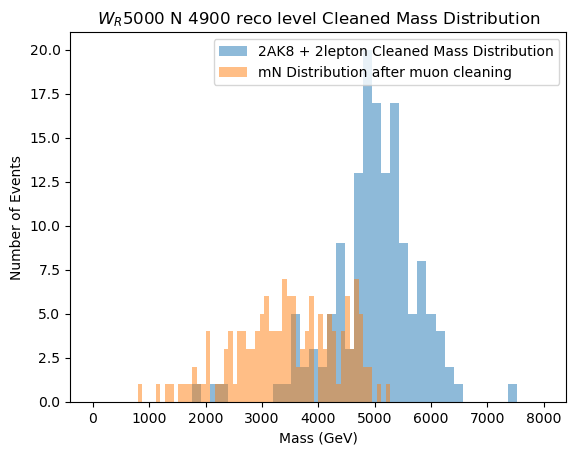

149


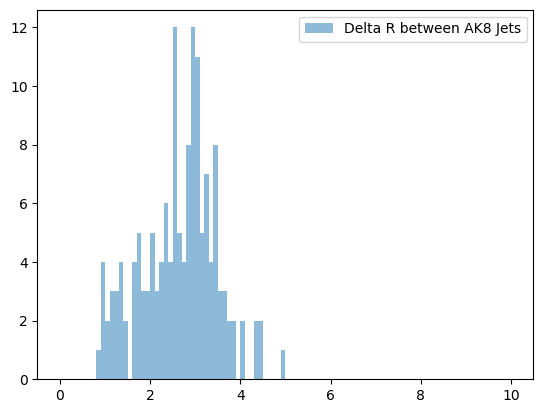

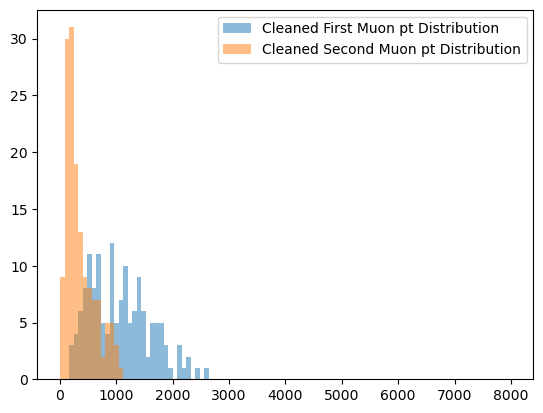

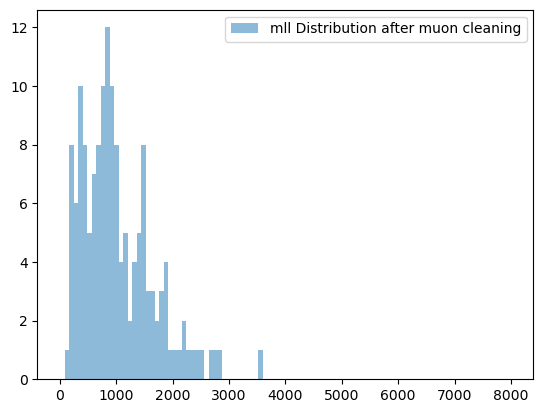

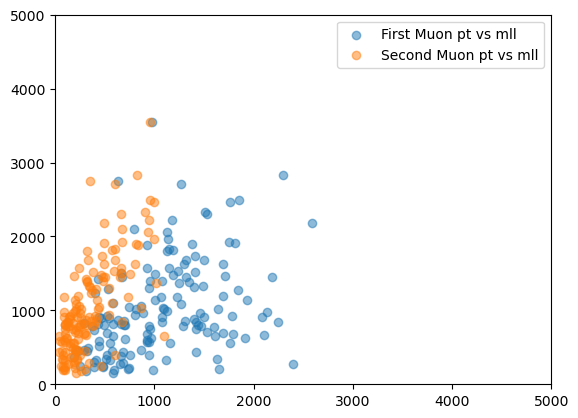

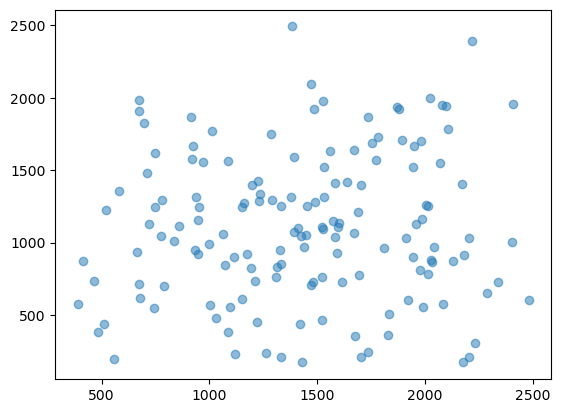

In [220]:
from importlib import import_module
import os
import sys
import argparse
import linecache
import uproot
import vector
import math
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from tqdm import tqdm  # ✅ 진행률 표시
import glob

vector.register_awkward()

sample = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV/Run3Summer22NanoAODv12_WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV_1.root"
file = uproot.open(sample)
events = file["Events"]

keys = events.keys()


def overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return target[mask]

def toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return toptagging[mask]

def sdm_toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return softdrop_mass[mask]

def btagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return btagging[mask]

def overlap_itself_removal(target, cleans, cut=0.4, dphi=False):
            mask = ak.ones_like(target["pt"], dtype=bool)
            for clean in cleans:
                pairs = ak.cartesian([target, clean], nested=True) # axis 0 = #event , axis 1 = target , axis 2 = clean
                delta = np.abs(pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
                mask = mask & (ak.min(delta, axis=2) > cut)
            return target[mask]
def find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return jets[closest_idx_per_obj]
def btag_find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return btagging[closest_idx_per_obj]
def Select(inputcoll,etamax,ptmin) :
    output = []
    for obj in inputcoll :
        if abs(obj.eta) < etamax and obj.pt > ptmin : output.append(obj)
    return output 





lhe_pdgid = events["LHEPart_pdgId"].array()
lhe_pt = events["LHEPart_pt"].array()
lhe_eta = events["LHEPart_eta"].array()
lhe_phi = events["LHEPart_phi"].array()
lhe_mass = events["LHEPart_mass"].array()

bottom_mask = (lhe_pdgid == 5) | (lhe_pdgid == -5)
lhe_muon_mask = (lhe_pdgid == 13) | (lhe_pdgid == -13)

lhe_particle  = ak.zip({
    "pt": lhe_pt,
    "eta": lhe_eta,
    "phi": lhe_phi,
    "mass": lhe_mass
}, with_name = "Momentum4D")

lhe_bottoms = lhe_particle[bottom_mask]
lhe_bottoms_eta = lhe_bottoms["eta"][:, 1:2]  
lhe_bottoms_phi = lhe_bottoms["phi"][:, 1:2]
lhe_bottoms_pt = lhe_bottoms["pt"][:, 1:2]  
lhe_bottoms_mass = lhe_bottoms["mass"][:, 1:2]  # bottom quark 1 = WR* mother

lhe_bottom2_eta = lhe_bottoms["eta"][:, 0:1]
lhe_bottom2_phi = lhe_bottoms["phi"][:, 0:1]
lhe_bottom2_pt = lhe_bottoms["pt"][:, 0:1]
lhe_bottom2_mass = lhe_bottoms["mass"][:, 0:1]  # top mother bottom quark

lhe_bottom = ak.zip({
    "eta": lhe_bottoms_eta,
    "phi": lhe_bottoms_phi,
    "pt": lhe_bottoms_pt,
    "mass": lhe_bottoms_mass
}, with_name = "Momentum4D")

lhe_bottom2 = ak.zip({
    "eta": lhe_bottom2_eta,
    "phi": lhe_bottom2_phi,
    "pt": lhe_bottom2_pt,
    "mass": lhe_bottom2_mass
}, with_name = "Momentum4D")

lhe_muons  = lhe_particle[lhe_muon_mask]
lhe_muons_eta = lhe_muons["eta"][:]
lhe_muons_phi = lhe_muons["phi"][:]
lhe_muons_pt = lhe_muons["pt"][:]
lhe_muons_mass = lhe_muons["mass"][:]

n_mother_muon_mass = lhe_muons_mass[:,0:1] 
n_mother_muon_pt = lhe_muons_pt[:,0:1] 
n_mother_muon_eta = lhe_muons_eta[:,0:1]
n_mother_muon_phi = lhe_muons_phi[:,0:1]

wr_mother_muon_mass = lhe_muons_mass[:,1:2]
wr_mother_muon_pt = lhe_muons_pt[:,1:2]
wr_mother_muon_eta = lhe_muons_eta[:,1:2]
wr_mother_muon_phi = lhe_muons_phi[:,1:2]

lhe_muon = ak.zip({
    "pt": lhe_muons_pt,
    "eta": lhe_muons_eta,
    "phi": lhe_muons_phi,
    "mass": lhe_muons_mass
}, with_name = "Momentum4D")

n_mother_muon = ak.zip({
    "pt": n_mother_muon_pt,
    "eta": n_mother_muon_eta,
    "phi": n_mother_muon_phi,
    "mass": n_mother_muon_mass
}, with_name = "Momentum4D")

wr_mother_muon = ak.zip({
    "pt": wr_mother_muon_pt,
    "eta": wr_mother_muon_eta,
    "phi": wr_mother_muon_phi,
    "mass": wr_mother_muon_mass
}, with_name = "Momentum4D")



genparticle_pdgid = events["GenPart_pdgId"].array()
genparticle_pt = events["GenPart_pt"].array()
genparticle_eta = events["GenPart_eta"].array()
genparticle_phi = events["GenPart_phi"].array()
genparticle_mass = events["GenPart_mass"].array()
genparticle_statusFlags = events["GenPart_statusFlags"].array()

top_mask = (genparticle_pdgid == 6) | (genparticle_pdgid == -6)


genparticle  = ak.zip({
    "pt": genparticle_pt,
    "eta": genparticle_eta,
    "phi": genparticle_phi,
    "mass": genparticle_mass
}, with_name = "Momentum4D")



gentops = genparticle[top_mask]
gentops_eta = gentops["eta"][:, 0:1]  
gentops_phi = gentops["phi"][:, 0:1]
gentops_pt = gentops["pt"][:, 0:1]  
gentops_mass = gentops["mass"][:, 0:1]  


gentop = ak.zip({
    "eta": gentops_eta,
    "phi": gentops_phi,
    "pt": gentops_pt,
    "mass": gentops_mass
}, with_name = "Momentum4D")


### reco level
ak4_eta = events["Jet_eta"].array()
ak4_phi = events["Jet_phi"].array()
ak4_pt = events["Jet_pt"].array()
ak4_flavor = events["Jet_hadronFlavour"].array()
ak4_mass = events["Jet_mass"].array()
btag = events["Jet_btagPNetB"].array()

ak4 = ak.zip({
        "pt": ak4_pt,
        "eta": ak4_eta,
        "phi": ak4_phi,
        "mass": ak4_mass
    }, with_name = "Momentum4D")

## Fatjet 
fatjet_pt = events["FatJet_pt"].array()
fatjet_eta = events["FatJet_eta"].array()
fatjet_phi = events["FatJet_phi"].array()
fatjet_mass = events["FatJet_mass"].array()

fatjets = ak.zip({
        "pt": fatjet_pt,
        "eta": fatjet_eta,
        "phi": fatjet_phi,
        "mass": fatjet_mass
    }, with_name="Momentum4D")

## muons
reco_muon_pt = events["Muon_pt"].array()
reco_muon_eta = events["Muon_eta"].array()
reco_muon_phi = events["Muon_phi"].array()
reco_muon_mass = events["Muon_mass"].array()

reco_muons = ak.zip({
        "pt": reco_muon_pt,
        "eta": reco_muon_eta,
        "phi": reco_muon_phi,
        "mass": reco_muon_mass
    }, with_name = "Momentum4D")


btagging = events["FatJet_btagDeepB"].array()
toptagging = events["FatJet_particleNetWithMass_TvsQCD"].array()
softdrop_mass = events["FatJet_msoftdrop"].array()

closest_muon1 = find_closest_jet(n_mother_muon, reco_muons)
closest_muon2 = find_closest_jet(wr_mother_muon, reco_muons)
closest_bjet = find_closest_jet(lhe_bottom, ak4)
closest_bak8jet = find_closest_jet(lhe_bottom, fatjets)
closest_ak8jet = find_closest_jet(gentop, fatjets)
notcleaned_mass = closest_muon1 + closest_muon2 + closest_bjet + closest_ak8jet
#plt.hist(notcleaned_mass.mass, bins=100, range=(0, 8000), alpha=0.5, label='Not Cleaned Mass Distribution')
#####################################################
cleaned_Nmother_muon_pt = []
cleaned_WR_mother_muon_pt = []
all_muon_pt = []
cleaned_ak4jet_pt = []
all_ak4jet_pt = []
cleaned_ak8jet_pt =[]
all_ak8jet_pt = []
#####################################################


first_muon = reco_muons[:, 0:1]  # 첫 번째 뮤온
second_muon = reco_muons[:, 1:2]  # 두 번째 뮤온
topmother_b_ak4jet = find_closest_jet(lhe_bottom2, ak4)
### 겹치는거 확인 

first_muon_cleaned = overlap_removal(first_muon, [reco_muons], cut=0.4)
second_muon_cleaned = overlap_removal(second_muon, [reco_muons], cut=0.4)


signaltop_cleaned = overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)
toptaggedak8 = toptagging_overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)
softdrop_mass_ak8 = sdm_toptagging_overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)
btaggingak8 = btagging_overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)

idx_desc = ak.argsort(-signaltop_cleaned["pt"], axis=1)

toptagging_mask = toptaggedak8 > 0.9  # ParticleNet T vs QCD threshold
softdrop_mass_mask = softdrop_mass_ak8 > 120  # SoftDrop mass threshold
total_top_mask = toptagging_mask & softdrop_mass_mask
print(total_top_mask)
cleaned_toptagged_ak8 = signaltop_cleaned[total_top_mask]  # top tagging 된 애들만 남김
idx_cleaned_toptagged_ak8 = ak.argsort(-cleaned_toptagged_ak8["pt"], axis=1)
leading_toptagged_ak8 = cleaned_toptagged_ak8[idx_cleaned_toptagged_ak8][:, 0:1]  # 가장 큰 pt

## top을 제외한 나머지 ak8 중 제일 큰 pt

cleaned_bjet_ak8 = signaltop_cleaned[~toptagging_mask]
idx_cleaned_bjet_ak8 = ak.argsort(-cleaned_bjet_ak8["pt"], axis=1)
leading_bjet_ak8 = cleaned_bjet_ak8[idx_cleaned_bjet_ak8][:, 0:1]  # 가장 큰 pt

print(leading_toptagged_ak8["pt"])
print(leading_bjet_ak8["pt"])
#plt.hist(ak.flatten(leading_toptagged_ak8["pt"]), bins=100, range=(0, 8000), alpha=0.5, label='Cleaned Leading Top Tagged AK8 Jet pt Distribution')
#plt.hist(ak.flatten(closest_ak8jet["pt"]), bins=100, range=(0, 8000), alpha=0.5, label='Cleaned Leading Top Tagged AK8 Jet pt Distribution')
#plt.hist(ak.flatten(leading_bjet_ak8["pt"]), bins=100, range=(0, 8000), alpha=0.5, label='Cleaned Leading B Tagged AK8 Jet pt Distribution')
#plt.hist(ak.flatten(closest_bak8jet["pt"]), bins=100, range=(0, 8000), alpha=0.5, label='Cleaned Leading B Tagged AK8 Jet pt Distribution')



#print(btaggingak8[~toptagging_mask])# top tagging 된 애들 제외하고 B tagging 점수 
#print("bjet tagged",ak.firsts(btaggingak8[~toptagging_mask]))
#plt.hist(ak.firsts(btaggingak8[~toptagging_mask]), bins=100, range=(0, 1), alpha=0.5, label='B tag score ak8 jet Distribution')
#plt.legend()
#plt.show()
#print("cleaned top tagged pt",signaltop_cleaned[toptagging_mask]["pt"])

#print( sum(1 for sub in signaltop_cleaned["pt"] if len(sub) >= 2))
### 빈 이벤트 빼고 연산하는 마스크 만들기
first_muon_cleaned_pt = ak.sum(first_muon_cleaned["pt"], axis=1)
second_muon_cleaned_pt = ak.sum(second_muon_cleaned["pt"], axis=1)
firstsorted_toptagged_ak8_pt = ak.sum(leading_toptagged_ak8["pt"], axis=1)
firstsorted_bjet_ak8_pt = ak.sum(leading_bjet_ak8["pt"], axis=1)


leftmask = (first_muon_cleaned_pt > 0.0) & (second_muon_cleaned_pt > 0.0) & (firstsorted_toptagged_ak8_pt > 0.0) & (firstsorted_bjet_ak8_pt > 0.0)
print(len(firstsorted_ak8_pt > 0))
first_muon_cleaned = first_muon_cleaned[leftmask]
second_muon_cleaned = second_muon_cleaned[leftmask]
leading_toptagged_ak8 = leading_toptagged_ak8[leftmask]
leading_bjet_ak8 = leading_bjet_ak8[leftmask]

combined_p4 = first_muon_cleaned + second_muon_cleaned + leading_toptagged_ak8 + leading_bjet_ak8
plt.hist(combined_p4.mass, bins=50, range=(0, 8000), alpha=0.5, label='2AK8 + 2lepton Cleaned Mass Distribution')
plt.xlabel('Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('$W_{R}$5000 N 4900 reco level Cleaned Mass Distribution')
mN = (second_muon_cleaned + leading_toptagged_ak8 + leading_bjet_ak8).mass
plt.hist(mN, bins=100, range=(0, 8000), alpha=0.5, label='mN Distribution after muon cleaning')
plt.legend()
plt.show()
print(len(combined_p4.mass))

## delta R between ak8 
ak8_deltaR = leading_toptagged_ak8.deltaR(leading_bjet_ak8)
plt.hist(ak.flatten(ak8_deltaR), bins=100, range=(0, 10), alpha=0.5, label='Delta R between AK8 Jets')
plt.legend()
plt.show()

##lepton pt 
plt.hist(ak.flatten(first_muon_cleaned["pt"]), bins=100, range=(0, 8000), alpha=0.5, label='Cleaned First Muon pt Distribution')
plt.hist(ak.flatten(second_muon_cleaned["pt"]), bins=100, range=(0, 8000), alpha=0.5, label='Cleaned Second Muon pt Distribution')
plt.legend()
plt.show()
##mll

mll = (first_muon_cleaned + second_muon_cleaned).mass
plt.hist(mll, bins=100, range=(0, 8000), alpha=0.5, label='mll Distribution after muon cleaning')
plt.legend()
plt.show()

plt.scatter(ak.flatten(first_muon_cleaned["pt"]), mll ,alpha=0.5, label='First Muon pt vs mll')
plt.scatter(ak.flatten(second_muon_cleaned["pt"]), mll, alpha=0.5, label='Second Muon pt vs mll')
plt.xlim(0, 5000)
plt.ylim(0, 5000)
plt.legend()
plt.show()

plt.scatter(ak.flatten(leading_toptagged_ak8["pt"]), ak.flatten(leading_bjet_ak8["pt"]), alpha=0.5, label='Leading Top Tagged AK8 Jet pt vs Leading B Tagged AK8 Jet pt')
plt.show()

## reco N 



## 그림으로 확인

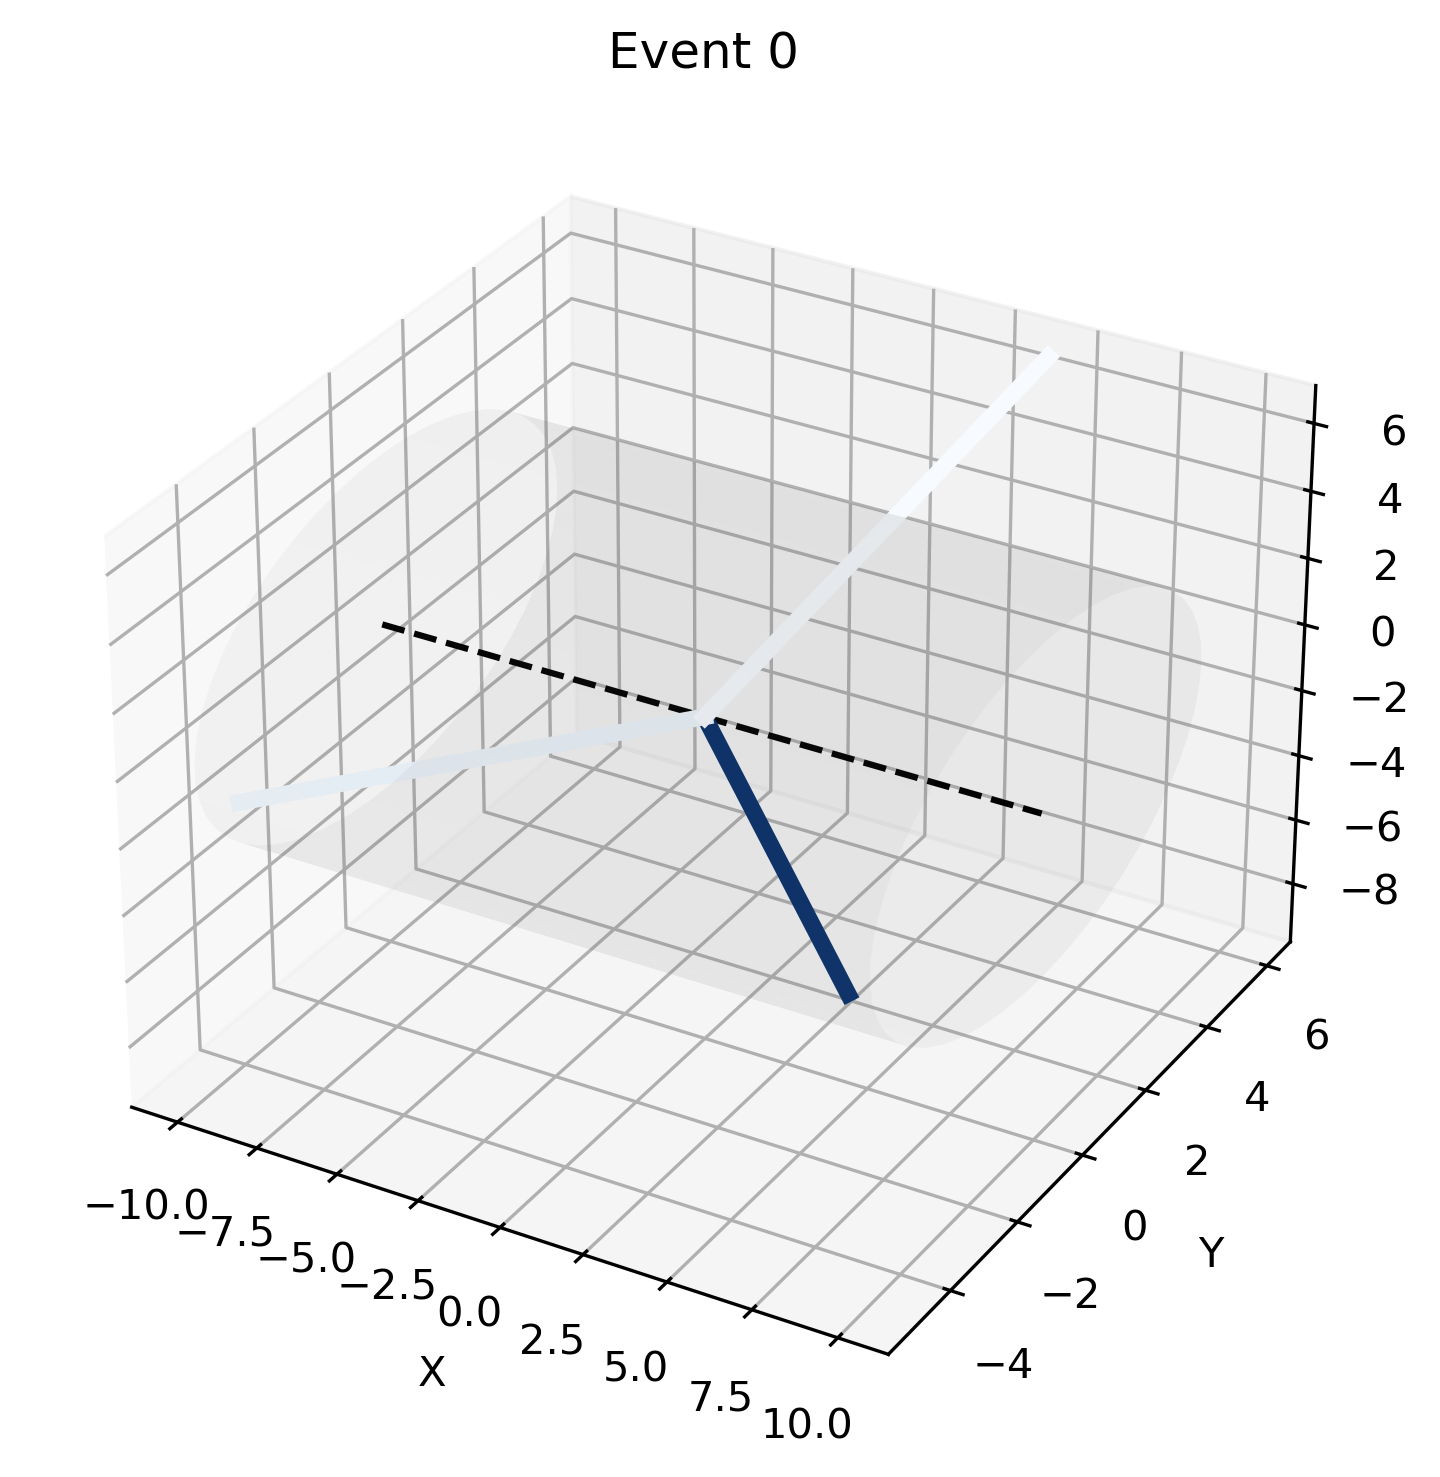

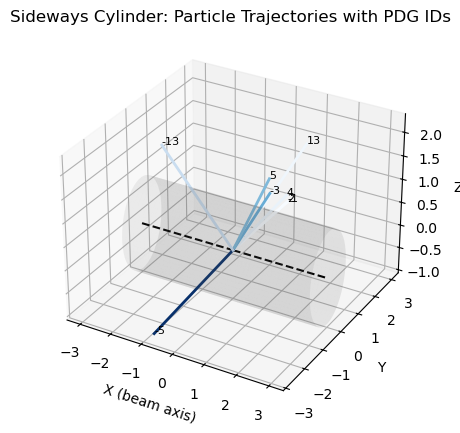

all b jet [2.38e+03, 2.21e+03, 588, 173, 111, 104, 86.1, 47, 18]


"\nimport os\nimport matplotlib\nmatplotlib.use('Agg')\nimport matplotlib.pyplot as plt\nfrom matplotlib.backends.backend_pdf import PdfPages\n\n\n\nplt.ioff()\n\noutput_path = '/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/using_matrix/cleaning/50002500_traj/lhe_trajectories.pdf'\nos.makedirs(os.path.dirname(output_path), exist_ok=True)\n\n\nwith PdfPages(output_path) as pdf:\n    for i in range(500):\n        plot_sideways_cylinder_trajectories_lhe(\n            lhe_final_state_eta[i],\n            lhe_final_state_phi[i],\n            lhe_final_state_pt[i],\n            lhe_final_state_pdgid[i],\n            R=5.0, t_max=10.0, num_t=100,\n            cmap='Blues', \n            figsize=(6, 4), dpi=200\n        )\n        fig = plt.gcf()        # get the current figure\n        pdf.savefig(fig)\n        plt.close(fig)\n"

In [75]:
def plot_multiple_trajectories(
    etas_list, phis_list, pts_list ,
    R=5.0, t_max=10.0, num_t=100,
    cmap='Blues', cols=3, figsize=(10, 5), dpi=300
):
    """
    Plot multiple particle events as 3D sideways cylinder trajectories.

    - etas_list, phis_list, pts_list, pdgids_list: list of per-event arrays
    - cols: number of columns in subplot grid
    """
    import math

    num_events = len(etas_list)
    rows = math.ceil(num_events / cols)

    fig = plt.figure(figsize=(figsize[0]*cols, figsize[1]*rows), dpi=dpi)
    
    for i in range(num_events):
        ax = fig.add_subplot(rows, cols, i+1, projection='3d')
        
        etas = np.asarray(etas_list[i])
        phis = np.asarray(phis_list[i])
        pts  = np.asarray(pts_list[i])
        #pdgids = np.asarray(pdgids_list[i], dtype=str)
        thetas = 2 * np.arctan(np.exp(-etas))

        norm = (pts - pts.min()) / (pts.max() - pts.min() + 1e-8)
        colormap = plt.get_cmap(cmap)
        
        # Cylinder mesh
        x_vals = np.linspace(-t_max, t_max, 50)
        phi_grid, x_grid = np.meshgrid(np.linspace(0, 2*np.pi, 50), x_vals)
        y_grid = R * np.cos(phi_grid)
        z_grid = R * np.sin(phi_grid)

        t = np.linspace(0, t_max, num_t)

        ax.plot_surface(x_grid, y_grid, z_grid, alpha=0.05, color='gray')
        ax.plot([-t_max, 0], [0,0], [0,0], '--', color='black')
        ax.plot([0, t_max], [0,0], [0,0], '--', color='black')

        for theta, phi, val, frac in zip(thetas, phis, pts, norm):
            x = t * np.cos(theta)
            y = t * np.sin(theta) * np.cos(phi)
            z = t * np.sin(theta) * np.sin(phi)
            ax.plot(x, y, z, color=colormap(frac), linewidth=4)
            #ax.text(x[-1], y[-1], z[-1], label, color='black', fontsize=8)

        ax.set_title(f'Event {i}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
    plt.tight_layout()
    plt.show()
def plot_sideways_cylinder_trajectories_lhe(etas, phis, pts, pdgids,
                                        R=1.0, t_max=3.0, num_t=100,
                                        cmap='Blues', figsize=(10,5), dpi=100):
    """
    3D visualization of particle trajectories on a sideways cylinder with PDG labels.
    
    Parameters:
    - etas:   list or array of pseudorapidities η
    - phis:   list or array of azimuthal angles φ (in radians)
    - pts:    list or array of transverse momenta pT
    - pdgids: list of PDG IDs corresponding to each trajectory
    - R:      cylinder radius
    - t_max:  max trajectory length along beam axis (X)
    - num_t:  number of sampling points along each trajectory
    - cmap:   Matplotlib colormap for brightness-only mapping
    - figsize: tuple for figure size in inches
    - dpi:     figure resolution
    """
    etas = np.asarray(etas)
    phis = np.asarray(phis)
    pts  = np.asarray(pts)
    pdgids = np.asarray(pdgids, dtype=str)
    thetas = 2 * np.arctan(np.exp(-etas))
    
    # Normalize pT for color mapping [0,1]
    norm = (pts - pts.min()) / (pts.max() - pts.min() + 1e-8)
    colormap = plt.get_cmap(cmap)
    
    # Cylinder mesh (sideways along X-axis)
    x_vals = np.linspace(-t_max, t_max, 50)
    phi_grid, x_grid = np.meshgrid(np.linspace(0, 2*np.pi, 50), x_vals)
    y_grid = R * np.cos(phi_grid)
    z_grid = R * np.sin(phi_grid)
    
    # Trajectory parameter
    t = np.linspace(0, t_max, num_t)
    
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(projection='3d')
    
    # Draw cylinder
    ax.plot_surface(x_grid, y_grid, z_grid, alpha=0.1, color='gray')
    # Beam lines (±X)
    ax.plot([-t_max, 0], [0,0], [0,0], '--', color='black')
    ax.plot([0, t_max], [0,0], [0,0], '--', color='black')
    
    # Plot and label trajectories
    for theta, phi, val, label, frac in zip(thetas, phis, pts, pdgids, norm):
        x = t * np.cos(theta)
        y = t * np.sin(theta) * np.cos(phi)
        z = t * np.sin(theta) * np.sin(phi)
        # Plot line with brightness only
        ax.plot(x, y, z, color=colormap(frac), linewidth=2)
        # Label at endpoint
        ax.text(x[-1], y[-1], z[-1], label, color='black', fontsize=8)
    
    ax.set_xlabel('X (beam axis)')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Sideways Cylinder: Particle Trajectories with PDG IDs')
    
    plt.show()
# Example usage with multiple events
#plot_multiple_trajectories( ak4["eta"][0:1], ak4["phi"][0:1], ak4["pt"][0:1])
#plot_multiple_trajectories( fatjets["eta"][0:1], fatjets["phi"][0:1], fatjets["pt"][0:1])
plot_multiple_trajectories( reco_muons["eta"][2:3], reco_muons["phi"][2:3], reco_muons["pt"][2:3])
muon_mask = (lhe_pdgid == 13) | (lhe_pdgid == -13) 
final_state_mask = (abs(lhe_pdgid) == 13) | (abs(lhe_pdgid) == 1) | (abs(lhe_pdgid) == 2) | (abs(lhe_pdgid) == 3) | (abs(lhe_pdgid) == 4) | (abs(lhe_pdgid) == 5) 
lhe_muon_pt = lhe_pt[muon_mask]
lhe_muon_eta = lhe_eta[muon_mask]
lhe_muon_phi = lhe_phi[muon_mask]
lhe_final_state_pt = lhe_pt[final_state_mask]
lhe_final_state_eta = lhe_eta[final_state_mask]
lhe_final_state_phi = lhe_phi[final_state_mask]
lhe_final_state_pdgid = lhe_pdgid[final_state_mask]
plot_sideways_cylinder_trajectories_lhe( lhe_final_state_eta[0], lhe_final_state_phi[0], lhe_final_state_pt[0], lhe_final_state_pdgid[0])
print("all b jet",ak4["pt"][0])
#print(signalb_cleaned["pt"][0])
'''
import os
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages



plt.ioff()

output_path = '/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/using_matrix/cleaning/50002500_traj/lhe_trajectories.pdf'
os.makedirs(os.path.dirname(output_path), exist_ok=True)


with PdfPages(output_path) as pdf:
    for i in range(500):
        plot_sideways_cylinder_trajectories_lhe(
            lhe_final_state_eta[i],
            lhe_final_state_phi[i],
            lhe_final_state_pt[i],
            lhe_final_state_pdgid[i],
            R=5.0, t_max=10.0, num_t=100,
            cmap='Blues', 
            figsize=(6, 4), dpi=200
        )
        fig = plt.gcf()        # get the current figure
        pdf.savefig(fig)
        plt.close(fig)
'''

### using genlevel
### 각 jet이랑 particle을 정확히 아는 경우 

/tmp/ipykernel_1262547/1568239669.py:52: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  a = np.array(muons)


Number of cleaned N mother muons: 432 , Number of cleaned WR mother muons: 431 , Number of total signal muons: 1000
Number of cleaned AK4 jets: 386 , Number of total signal AK4 jets: 500
Number of cleaned AK8 jets (not include signal b): 84 , Number of total signal AK8 jets: 500
47


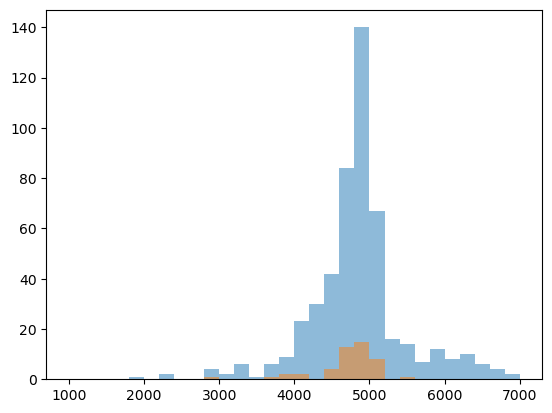

In [9]:

from importlib import import_module
import os
import sys
import argparse
import linecache
import uproot
import vector
import math
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from tqdm import tqdm  # ✅ 진행률 표시
import glob

vector.register_awkward()

sample = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-2500_13p6TeV/Run3Summer22NanoAODv12_WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-2500_13p6TeV_1.root"
file = uproot.open(sample)
events = file["Events"]

keys = events.keys()
GEN_STATUS_FLAGS = {
    "isPrompt": 0,
    "isDecayedLeptonHadron": 1,
    "isTauDecayProduct": 2,
    "isPromptTauDecayProduct": 3,
    "isDirectTauDecayProduct": 4,
    "isDirectPromptTauDecayProduct": 5,
    "isDirectHadronDecayProduct": 6,
    "isHardProcess": 7,
    "fromHardProcess": 8,
    "isHardProcessTauDecayProduct": 9,
    "isDirectHardProcessTauDecayProduct": 10,
    "fromHardProcessBeforeFSR": 11,
    "isFirstCopy": 12,
    "isLastCopy": 13,
    "isLastCopyBeforeFSR": 14,
}

def decode_gen_status_flags(statusFlags):
    flags = {}
    for name, bit in GEN_STATUS_FLAGS.items():
        flags[name] = ((statusFlags >> bit) & 1).astype(bool)
    return flags
def is_hard_process(statusFlags):
    return ((statusFlags >> 7) & 1).astype(bool)
def muon_status_list():
    muon_mask = (genparticle_pdgid == 13) | (genparticle_pdgid == -13)
    muon_status = genparticle_statusFlags[muon_mask]
    muon_hardprocess_list = []
    for muons in muon_status:
        a = np.array(muons)
        status = is_hard_process(a)
        muon_hardprocess_list.append(status)
    return muon_hardprocess_list
def overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return target[mask]
def overlap_itself_removal(target, cleans, cut=0.4, dphi=False):
            mask = ak.ones_like(target["pt"], dtype=bool)
            for clean in cleans:
                pairs = ak.cartesian([target, clean], nested=True) # axis 0 = #event , axis 1 = target , axis 2 = clean
                delta = np.abs(pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
                mask = mask & (ak.min(delta, axis=2) > cut)
            return target[mask]
def find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return jets[closest_idx_per_obj]
def Select(inputcoll,etamax,ptmin) :
    output = []
    for obj in inputcoll :
        if abs(obj.eta) < etamax and obj.pt > ptmin : output.append(obj)
    return output 





lhe_pdgid = events["LHEPart_pdgId"].array()
lhe_pt = events["LHEPart_pt"].array()
lhe_eta = events["LHEPart_eta"].array()
lhe_phi = events["LHEPart_phi"].array()
lhe_mass = events["LHEPart_mass"].array()

bottom_mask = (lhe_pdgid == 5) | (lhe_pdgid == -5)
lhe_muon_mask = (lhe_pdgid == 13) | (lhe_pdgid == -13)

lhe_particle  = ak.zip({
    "pt": lhe_pt,
    "eta": lhe_eta,
    "phi": lhe_phi,
    "mass": lhe_mass
}, with_name = "Momentum4D")

lhe_bottoms = lhe_particle[bottom_mask]
lhe_bottoms_eta = lhe_bottoms["eta"][:, 1:2]  
lhe_bottoms_phi = lhe_bottoms["phi"][:, 1:2]
lhe_bottoms_pt = lhe_bottoms["pt"][:, 1:2]  
lhe_bottoms_mass = lhe_bottoms["mass"][:, 1:2]  # bottom quark 1 = WR* mother

lhe_bottom2_eta = lhe_bottoms["eta"][:, 0:1]
lhe_bottom2_phi = lhe_bottoms["phi"][:, 0:1]
lhe_bottom2_pt = lhe_bottoms["pt"][:, 0:1]
lhe_bottom2_mass = lhe_bottoms["mass"][:, 0:1]  # top mother bottom quark

lhe_bottom = ak.zip({
    "eta": lhe_bottoms_eta,
    "phi": lhe_bottoms_phi,
    "pt": lhe_bottoms_pt,
    "mass": lhe_bottoms_mass
}, with_name = "Momentum4D")

lhe_bottom2 = ak.zip({
    "eta": lhe_bottom2_eta,
    "phi": lhe_bottom2_phi,
    "pt": lhe_bottom2_pt,
    "mass": lhe_bottom2_mass
}, with_name = "Momentum4D")

lhe_muons  = lhe_particle[lhe_muon_mask]
lhe_muons_eta = lhe_muons["eta"][:]
lhe_muons_phi = lhe_muons["phi"][:]
lhe_muons_pt = lhe_muons["pt"][:]
lhe_muons_mass = lhe_muons["mass"][:]

n_mother_muon_mass = lhe_muons_mass[:,0:1] 
n_mother_muon_pt = lhe_muons_pt[:,0:1] 
n_mother_muon_eta = lhe_muons_eta[:,0:1]
n_mother_muon_phi = lhe_muons_phi[:,0:1]

wr_mother_muon_mass = lhe_muons_mass[:,1:2]
wr_mother_muon_pt = lhe_muons_pt[:,1:2]
wr_mother_muon_eta = lhe_muons_eta[:,1:2]
wr_mother_muon_phi = lhe_muons_phi[:,1:2]

lhe_muon = ak.zip({
    "pt": lhe_muons_pt,
    "eta": lhe_muons_eta,
    "phi": lhe_muons_phi,
    "mass": lhe_muons_mass
}, with_name = "Momentum4D")

n_mother_muon = ak.zip({
    "pt": n_mother_muon_pt,
    "eta": n_mother_muon_eta,
    "phi": n_mother_muon_phi,
    "mass": n_mother_muon_mass
}, with_name = "Momentum4D")

wr_mother_muon = ak.zip({
    "pt": wr_mother_muon_pt,
    "eta": wr_mother_muon_eta,
    "phi": wr_mother_muon_phi,
    "mass": wr_mother_muon_mass
}, with_name = "Momentum4D")



genparticle_pdgid = events["GenPart_pdgId"].array()
genparticle_pt = events["GenPart_pt"].array()
genparticle_eta = events["GenPart_eta"].array()
genparticle_phi = events["GenPart_phi"].array()
genparticle_mass = events["GenPart_mass"].array()
genparticle_statusFlags = events["GenPart_statusFlags"].array()

top_mask = (genparticle_pdgid == 6) | (genparticle_pdgid == -6)
muon_mask = (genparticle_pdgid == 13) | (genparticle_pdgid == -13)

genparticle  = ak.zip({
    "pt": genparticle_pt,
    "eta": genparticle_eta,
    "phi": genparticle_phi,
    "mass": genparticle_mass
}, with_name = "Momentum4D")



gentops = genparticle[top_mask]
gentops_eta = gentops["eta"][:, 0:1]  
gentops_phi = gentops["phi"][:, 0:1]
gentops_pt = gentops["pt"][:, 0:1]  
gentops_mass = gentops["mass"][:, 0:1]  

genmuons = genparticle[muon_mask]
genmuons_eta = genmuons["eta"][:]
genmuons_phi = genmuons["phi"][:]
genmuons_pt = genmuons["pt"][:]
genmuons_mass = genmuons["mass"][:]

gentop = ak.zip({
    "eta": gentops_eta,
    "phi": gentops_phi,
    "pt": gentops_pt,
    "mass": gentops_mass
}, with_name = "Momentum4D")

genmuon = ak.zip({
    "pt": genmuons_pt,
    "eta": genmuons_eta,
    "phi": genmuons_phi,
    "mass": genmuons_mass
}, with_name = "Momentum4D")

dressed_lepton_pdgid = events["GenDressedLepton_pdgId"].array()
dressed_lepton_pt = events["GenDressedLepton_pt"].array()

genjet_pt = events["GenJet_pt"].array()
genjet_eta = events["GenJet_eta"].array()
genjet_phi = events["GenJet_phi"].array()
genjet_mass = events["GenJet_mass"].array()

genjet = ak.zip({
    "pt": genjet_pt,
    "eta": genjet_eta,
    "phi": genjet_phi,
    "mass": genjet_mass
}, with_name = "Momentum4D")

genjetak8_pt = events["GenJetAK8_pt"].array()
genjetak8_eta = events["GenJetAK8_eta"].array()
genjetak8_phi = events["GenJetAK8_phi"].array()
genjetak8_mass = events["GenJetAK8_mass"].array()

genjetak8 = ak.zip({
    "pt": genjetak8_pt,
    "eta": genjetak8_eta,
    "phi": genjetak8_phi,
    "mass": genjetak8_mass
}, with_name = "Momentum4D")

jet_pt = events["Jet_pt"].array()

muon_pt = events["Muon_pt"].array()


#####################################################
cleaned_Nmother_muon_pt = []
cleaned_WR_mother_muon_pt = []
all_muon_pt = []
cleaned_ak4jet_pt = []
all_ak4jet_pt = []
cleaned_ak8jet_pt =[]
all_ak8jet_pt = []
#####################################################

hardmuons =genmuon[muon_status_list()] ## hard process gen level muons 
nmother_muon = find_closest_jet(n_mother_muon, hardmuons)
wrmother_muon = find_closest_jet(wr_mother_muon, hardmuons)

ak8jet = find_closest_jet(gentop, genjetak8)
ak4jet = find_closest_jet(lhe_bottom, genjet)
topmother_b_ak4jet = find_closest_jet(lhe_bottom2, genjet)
## 1. 뮤온은 자기 자신끼리만 안 겹치면 그대로 사용
overlap_nmother_cleaned = overlap_removal(nmother_muon, [genmuon]) #lepton lepton cleaning
overlap_WR_mother_cleaned = overlap_removal(wrmother_muon, [genmuon]) #lepton lepton cleaning

cleaned_Nmother_muon_pt.append(overlap_nmother_cleaned["pt"])
cleaned_WR_mother_muon_pt.append(overlap_WR_mother_cleaned["pt"])
all_muon_pt.append(hardmuons["pt"])
# 2. b jet은 뮤온이랑만 안 겹치면 그대로 사용 
overlap_ak4_cleaned = overlap_removal(ak4jet, [genmuon, genjet])
    
cleaned_ak4jet_pt.append(overlap_ak4_cleaned["pt"])
all_ak4jet_pt.append(ak4jet["pt"])
# 3. fatjet은 뮤온이랑 b jet이랑 안 겹쳐야 사용

# top mother b 가 안 들어있는 jet들 overlap_itself_removal 사용해서 자기 자신은 지움 
overlap_topmother_b_cleaned = overlap_itself_removal(genjet, [topmother_b_ak4jet])
overlap_fatjet_cleaned_include_signalb = overlap_removal(ak8jet, [genmuon , overlap_topmother_b_cleaned ,genjetak8], cut=0.8)
cleaned_ak8jet_pt.append(overlap_fatjet_cleaned_include_signalb["pt"])
all_ak8jet_pt.append(ak8jet["pt"])

#####################################################
#####################################################

num_cleannmuon =len((ak.flatten(ak.flatten(cleaned_Nmother_muon_pt))))
num_cleanwrmuon = (len((ak.flatten(ak.flatten(cleaned_WR_mother_muon_pt)))))
num_totalsigmuon = (len((ak.flatten(ak.flatten(all_muon_pt)))))
num_cleanak4 = (len((ak.flatten(ak.flatten(cleaned_ak4jet_pt)))))
num_totalsigak4 = (len((ak.flatten(ak.flatten(all_ak4jet_pt)))))
num_cleanak8 = len((ak.flatten(ak.flatten(cleaned_ak8jet_pt))))
num_totalsigak8 = len((ak.flatten(ak.flatten(all_ak8jet_pt))))

print(f"Number of cleaned N mother muons: {num_cleannmuon} , Number of cleaned WR mother muons: {num_cleanwrmuon} , Number of total signal muons: {num_totalsigmuon}")
print(f"Number of cleaned AK4 jets: {num_cleanak4} , Number of total signal AK4 jets: {num_totalsigak4}")
print(f"Number of cleaned AK8 jets (not include signal b): {num_cleanak8} , Number of total signal AK8 jets: {num_totalsigak8}")


nocut_mass = ak4jet + ak8jet + nmother_muon + wrmother_muon
mass = ak.flatten(nocut_mass.mass)
plt.hist(mass, bins=30, range=(1000, 7000), alpha=0.5, label='No Cut Mass Distribution')




overlap_nmother_cleaned_pts = ak.sum(overlap_nmother_cleaned["pt"], axis=1)
overlap_WR_mother_cleaned_pts = ak.sum(overlap_WR_mother_cleaned["pt"], axis=1)
overlap_ak4_cleaned_pts = ak.sum(overlap_ak4_cleaned["pt"], axis=1)
overlap_fatjet_cleaned_include_signalb_pts = ak.sum(overlap_fatjet_cleaned_include_signalb["pt"], axis=1)


leftmask = (overlap_nmother_cleaned_pts > 0.0) & (overlap_WR_mother_cleaned_pts > 0.0) & (overlap_ak4_cleaned_pts > 0.0) & (overlap_fatjet_cleaned_include_signalb_pts > 0.0)

overlap_nmother_cleaned = overlap_nmother_cleaned[leftmask]
overlap_WR_mother_cleaned = overlap_WR_mother_cleaned[leftmask]
overlap_ak4_cleaned = overlap_ak4_cleaned[leftmask]
overlap_fatjet_cleaned_include_signalb = overlap_fatjet_cleaned_include_signalb[leftmask]

combined_p4 = overlap_nmother_cleaned + overlap_WR_mother_cleaned + overlap_ak4_cleaned + overlap_fatjet_cleaned_include_signalb
plt.hist(combined_p4.mass, bins=30, range=(1000, 7000), alpha=0.5, label='Cleaned Mass Distribution')
print(len(combined_p4.mass))

### pt 순서대로 골랐을 때 (gen)

lhe bottom [[1.14e+03], [972], [137], [1.08e+03], [391], ..., [986], [143], [480], [207]]
lhe bottom from top [[80.5], [969], [324], [176], [288], ..., [479], [83.7], [254], [585], [408]]
lhe muon [[998, 1.53e+03], [372, 1.24e+03], [525, ...], ..., [518, 840], [793, 301]]
all genjet [1.39e+03, 1.25e+03, 926, 394, 108, 52, 48.8, 15.9]
signal b jet [[1.14e+03], [926], [103], [960], [349], ..., [981], [165], [486], [11.2]]
all gen muon [1.52e+03, 1.52e+03, 1e+03, 5.31, 5.2]
hard process muon [[1.52e+03, 1e+03], [1.27e+03, 370], [...], ..., [...], [902, 489], [320, 802]]
gen top [[186], [1.4e+03], [1.71e+03], [986], ..., [279], [896], [1.48e+03], [1.17e+03]]
[108]


/tmp/ipykernel_1262547/1568239669.py:52: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  a = np.array(muons)


431
firstmuon cleaned [[1.52e+03], [], [1.46e+03], [1.9e+03], ..., [400], [692], [], [320]]
second muon cleaned [[1e+03], [370], [530], [469], [900], ..., [616], [874], [664], [], [802]]
bjet cleaned [[1.14e+03], [1.39e+03], [83.5], [960], ..., [874], [1.37e+03], [1.08e+03]]
255
[[1.14e+03, 108], [1.51e+03], [], ..., [...], [1.39e+03, 599, 308], [1.16e+03]]
[108, 52, 48.8, 15.9]


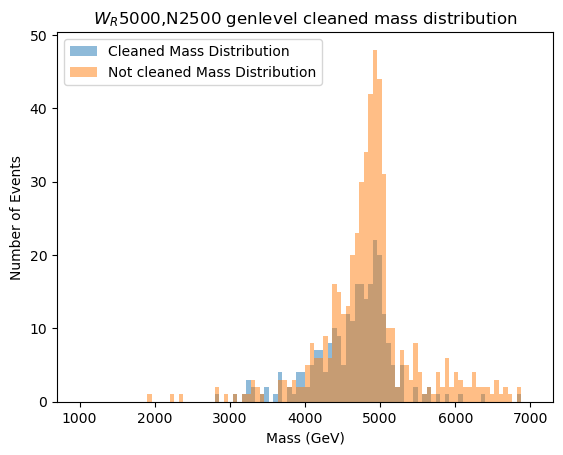

In [10]:

print("lhe bottom",lhe_bottom["pt"])
print("lhe bottom from top",lhe_bottom2["pt"])
print("lhe muon",lhe_muon["pt"])
print("all genjet",genjet["pt"][1])
print("signal b jet",ak4jet["pt"])
print("all gen muon",genmuon["pt"][0])
print("hard process muon",genmuon[muon_status_list()]["pt"])
print("gen top",gentop["pt"])
print(ak8jet["pt"][0])


### 어차피 뮤온 중에서는 제일 큰거 두개가 거의 무조건 시그널임 
first_muon = genmuon[muon_status_list()][:, 0:1]  # 첫 번째 뮤온
second_muon = genmuon[muon_status_list()][:, 1:2]  # 두 번째 뮤온

#### 겹치는지 확인 
first_muon_cleaned = overlap_removal(first_muon, [genmuon], cut=0.4)
second_muon_cleaned = overlap_removal(second_muon, [genmuon], cut=0.4)
print( len(ak.flatten(first_muon_cleaned["pt"])))
print("firstmuon cleaned",first_muon_cleaned["pt"])
print("second muon cleaned",second_muon_cleaned["pt"])
### ak4 중에서 렙톤 근처에 없고 근처에 ak4없는것 중에 제일 큰 pt
signalb_cleaned = overlap_removal(genjet, [genmuon, genjet], cut=0.4)
signalb_cleaned_sorted = signalb_cleaned[ak.argsort(signalb_cleaned["pt"], axis = 1,ascending=False)]
signalb_cleaend_sorted = signalb_cleaned_sorted[:, 0:1]  # 가장 큰 pt를 가진 jet만 선택
print("bjet cleaned",signalb_cleaend_sorted["pt"])
### ak8 중에서 렙톤 근처에 없고 위에서 뽑은 ak4가 안 들어있는거 
signaltop_cleaned = overlap_removal(genjetak8, [genmuon, genjetak8 , signalb_cleaend_sorted], cut=0.8)
signaltop_cleaned_sorted = signaltop_cleaned[ak.argsort(signaltop_cleaned["pt"], axis = 1, ascending=False)]
signaltop_cleaned_sorted = signaltop_cleaned_sorted[:, 0:1]

####빈 이벤트 빼고 연산하는 마스크 만들기 
first_muon_cleaned_pt = ak.sum(first_muon_cleaned["pt"], axis=1)
second_muon_cleaned_pt = ak.sum(second_muon_cleaned["pt"], axis=1)
signalb_cleaned_pt = ak.sum(signalb_cleaend_sorted["pt"], axis=1)
signaltop_cleaned_pt = ak.sum(signaltop_cleaned_sorted["pt"], axis=1)  

leftmask = (first_muon_cleaned_pt > 0.0) & (second_muon_cleaned_pt > 0.0) & (signalb_cleaned_pt > 0.0) & (signaltop_cleaned_pt > 0.0)

first_muon_cleaned = first_muon_cleaned[leftmask]
second_muon_cleaned = second_muon_cleaned[leftmask]
signalb_cleaend_sorted = signalb_cleaend_sorted[leftmask]
signaltop_cleaned_sorted = signaltop_cleaned_sorted[leftmask]

combined_p4 = first_muon_cleaned + second_muon_cleaned + signalb_cleaend_sorted + signaltop_cleaned_sorted
plt.hist(combined_p4.mass, bins=100, range=(1000, 7000), alpha=0.5, label='Cleaned Mass Distribution')
print(len(combined_p4.mass))


nocut_mass = ak4jet + ak8jet + first_muon + second_muon
mass = ak.flatten(nocut_mass.mass)
plt.hist(mass, bins=100, range=(1000, 7000), alpha=0.5, label='Not cleaned Mass Distribution')

plt.legend()
plt.xlabel('Mass (GeV)')
plt.ylabel('Number of Events')
plt.title("$W_{R}$5000,N2500 genlevel cleaned mass distribution")



############# 뮤온 , fatjet , bjet 순서인 경우 

## 뮤온 클리닝은 동일 

## fatjet 주변에 fatjet 없고 , 뮤온 없어야 함 
signaltop_cleaned2 = overlap_removal(genjetak8, [genmuon, genjetak8], cut=0.8)
print(signaltop_cleaned2["pt"]) ## 이거 b jet 들어오긴한데 top tagger로 없앨 수 있을 거 같은데 
signalb_cleaned2 = overlap_removal(genjet, [genmuon, genjetak8, genjet], cut=0.4)
print(signalb_cleaned2["pt"][1]) ## 이거 b jet 들어오긴한데 top tagger로 없앨 수 있을 거 같은데 그래도 ak8가 근처에 있으면 사라지니까 다 없어짐 

### cleaning + cut adjusting 